# **Unsmoothing of linear time series**

Let's first import different dependencies and the data:

In [877]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns

And put some global paramters:

We will first choose a time frame for the volatility computation.

As indicated by the PRIIPS regulation we will use a 5 years timeframe for the volatility computation.

Also, we will remove the year 2023 because some datas are missing.

In [878]:
vol_start_date = "31-12-2017"
vol_end_date = "31-12-2022"

starting_date = "31-03-2007" # rebasing in order to compare cumulative returns

In [879]:
alternative_data_raw = pd.read_excel('EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)
alternative_data_raw.tail(10)

,Commodity - USD Unhedged,Global Property USD Unhedged,Hedge Fund DJ - USD Unhedged,Infrastructure Debt - USD Unhedged,Infrastructure Equity Listed - USD Unhedged,Infrastructure Equity USD Unhedged,Nature Capital - USD Hedged,Private Equity USD Unhedged,UK Property Direct - USD Unhedged
QUARTER,,,,,,,,,
2021-Q2,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508
2021-Q3,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387
2021-Q4,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135
2022-Q1,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837
2022-Q2,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907
2023-Q2,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599


# **I. Data Analysis**
## Preprocessing

In [880]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_Listed_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
QUARTER,,,,,,,,,,,,,,,,,,
2021-04-01,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508,0.133047,0.094214,0.030222,0.020519,NaN,0.017745,0.111440,0.167016,0.056565
2021-07-01,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387,0.065891,-0.007264,0.011920,0.003692,NaN,-0.014956,0.050009,0.043820,0.009733
2021-10-01,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135,-0.015634,0.103686,0.009376,-0.003600,NaN,0.107533,0.060127,0.102127,0.086033
2022-01-01,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837,0.255475,-0.037686,0.021344,-0.058718,0.074704,-0.023148,0.106156,-0.116226,-0.047506
2022-04-01,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741,-0.056630,-0.172332,-0.022973,-0.049684,-0.074240,-0.102697,0.063878,-0.242661,-0.185118
2022-07-01,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-10-01,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-01-01,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827
2023-04-01,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599,-0.025624,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544


##  Data Visualisation

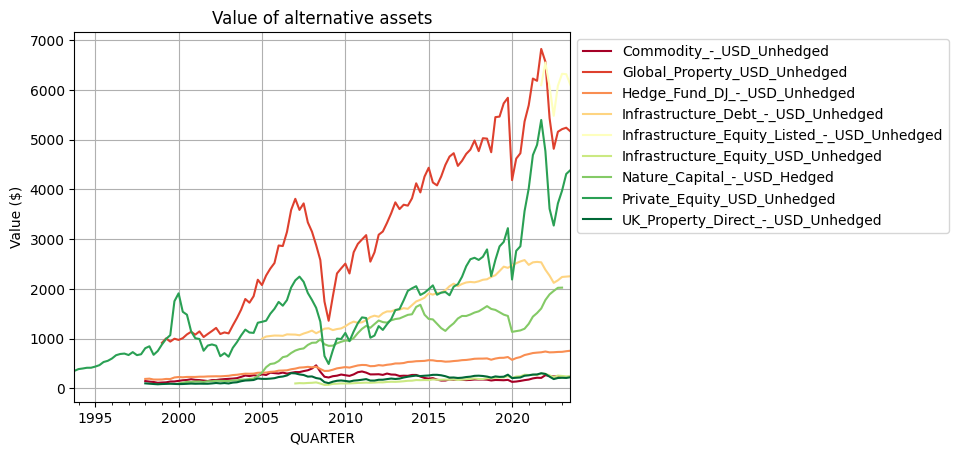

In [881]:
(alternative_data.iloc[:,0:9]
.plot(cmap = 'RdYlGn',grid=True,ylabel='Value ($)', title='Value of alternative assets')
.legend(bbox_to_anchor = (1,1)))

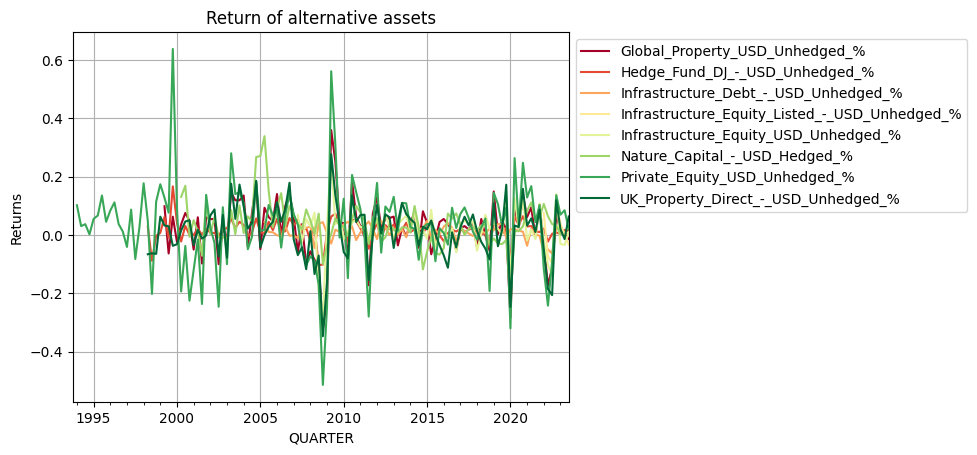

In [882]:
(alternative_data.iloc[:,10:]
.plot(cmap = 'RdYlGn',grid=True,ylabel='Returns', title='Return of alternative assets')
.legend(bbox_to_anchor = (1,1)))

##  Stationarity analysis 

In [883]:
unit_test = {name: (adfuller(alternative_data[name].dropna())[0], adfuller(alternative_data[name].dropna())[1]) 
       for name in alternative_data.iloc[:,10:].columns}

(pd.DataFrame(unit_test, index = ['value','p-value']).T.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn'))

,value,p-value
Global_Property_USD_Unhedged_%,-8.58,0.00
Hedge_Fund_DJ_-_USD_Unhedged_%,-8.99,0.00
Infrastructure_Debt_-_USD_Unhedged_%,-7.14,0.00
Infrastructure_Equity_Listed_-_USD_Unhedged_%,-2.62,0.09
Infrastructure_Equity_USD_Unhedged_%,-8.06,0.00
Nature_Capital_-_USD_Hedged_%,-5.63,0.00
Private_Equity_USD_Unhedged_%,-9.30,0.00
UK_Property_Direct_-_USD_Unhedged_%,-8.59,0.00


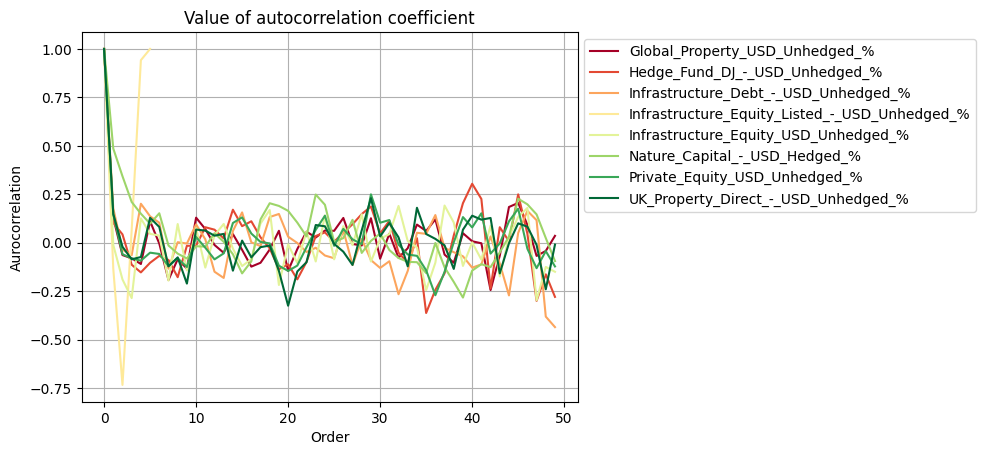

In [884]:
serial_correlation = pd.DataFrame({name:  [alternative_data[name].dropna().autocorr(k) for k in range (50)]
                       for name in alternative_data.iloc[:,10:].columns})

(serial_correlation
.plot(grid = True, cmap  = 'RdYlGn', xlabel='Order', ylabel ='Aurocorrelation', title = 'Value of autocorrelation coefficient' )
.legend(bbox_to_anchor = (1,1)))

In [885]:
def cumulated_returns(serie):
    return (1 + serie).cumprod() - 1

# **II. Naive Methods**
##  Linear

In [886]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index))
            .resample('QE')
            .last() #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ['Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged'])) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_return = alternative_data.iloc[:,8:]

In [887]:
price = alternative_data.loc['31-03-2007':].iloc[:,:8]
linear_returns = price.resample('ME').interpolate(method = 'linear').pct_change(fill_method = None)

In [888]:
linear_returns

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
QUARTER,,,,,,,,
2007-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,-0.000429,-0.019504,0.017299,-0.003971,0.022482,0.012454,0.011437,-0.023148
2007-05-31,-0.000429,-0.019892,0.017005,-0.003987,0.021988,0.012300,0.011307,-0.023696
2007-06-30,-0.000430,-0.020296,0.016721,-0.004003,0.021515,0.012151,0.011181,-0.024271
2007-07-31,0.020809,0.012186,0.003763,0.010769,-0.008341,0.005997,-0.015508,-0.014237
...,...,...,...,...,...,...,...,...
2023-05-31,-0.008615,0.001806,0.005655,0.001070,-0.011745,0.000000,0.027330,-0.004872
2023-06-30,-0.008690,0.001803,0.005623,0.001069,-0.011885,0.000000,0.026603,-0.004896
2023-07-31,0.013123,-0.004701,0.004335,0.001008,0.003120,0.000000,0.005994,0.020984


Text(0.5, 1.0, 'Linear Interpolation')

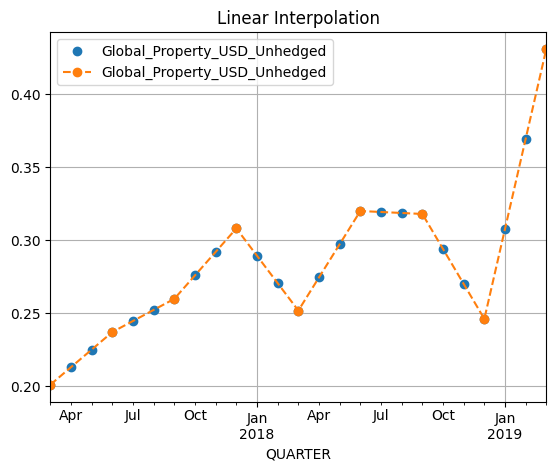

In [889]:
fig, axis = plt.subplots()

(linear_returns.Global_Property_USD_Unhedged
.agg(cumulated_returns)
.loc['31-03-2017' : '31-03-2019']
.plot(ax = axis, style = 'o',grid = True)
.legend())


(price.Global_Property_USD_Unhedged
 .resample('ME')
 .interpolate('linear')
 .pct_change()
 .agg(cumulated_returns)
 .loc['31-03-2017': '31-03-2019']
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True)
 .legend())

axis.set_title('Linear Interpolation')

## Correlation Matrix

In [890]:
(linear_returns.loc['2017-12-31':'2022-12-31'].corr()
.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex(f"tex_figure/correl_matrix_linear_interpotaled.tex")
)

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
Commodity_-_USD_Unhedged,1.00,0.66,0.81,-0.22,0.43,0.77,0.59,0.61
Global_Property_USD_Unhedged,0.66,1.00,0.83,0.32,0.80,0.53,0.92,0.88
Hedge_Fund_DJ_-_USD_Unhedged,0.81,0.83,1.00,0.01,0.62,0.62,0.88,0.73
Infrastructure_Debt_-_USD_Unhedged,-0.22,0.32,0.01,1.00,0.43,-0.43,0.33,0.35
Infrastructure_Equity_USD_Unhedged,0.43,0.80,0.62,0.43,1.00,0.27,0.77,0.86
Nature_Capital_-_USD_Hedged,0.77,0.53,0.62,-0.43,0.27,1.00,0.45,0.38
Private_Equity_USD_Unhedged,0.59,0.92,0.88,0.33,0.77,0.45,1.00,0.84
UK_Property_Direct_-_USD_Unhedged,0.61,0.88,0.73,0.35,0.86,0.38,0.84,1.00


## Volatility

In [891]:
def volatility_from_month(x):
    return np.sqrt(12)*x.std()

In [892]:
linear_returns.loc['2017-12-31':'2022-12-31'].agg(volatility_from_month)

Commodity_-_USD_Unhedged              0.110196
Global_Property_USD_Unhedged          0.124947
Hedge_Fund_DJ_-_USD_Unhedged          0.038985
Infrastructure_Debt_-_USD_Unhedged    0.034297
Infrastructure_Equity_USD_Unhedged    0.096100
Nature_Capital_-_USD_Hedged           0.081746
Private_Equity_USD_Unhedged           0.179881
UK_Property_Direct_-_USD_Unhedged     0.132688
dtype: float64

## **Quadratique**

In [893]:
price = alternative_data.loc['31-03-2007':].iloc[:,:8]
quadratic_return = price.resample('ME').interpolate(method = 'quadratic').pct_change()

Text(0.5, 1.0, 'Quadratic Interpolation')

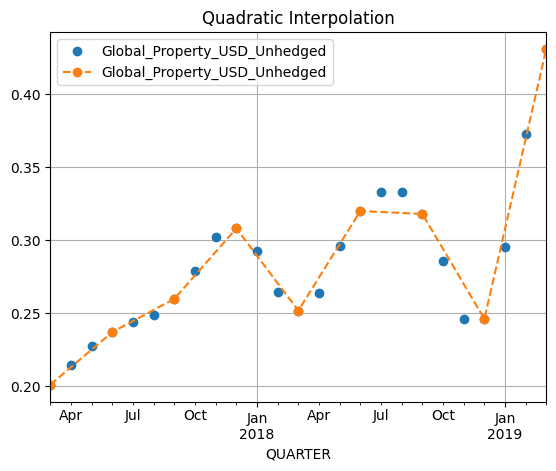

In [894]:
fig, axis = plt.subplots()

(quadratic_return.Global_Property_USD_Unhedged
 .agg(cumulated_returns)
 .loc['31-03-2017' : '31-03-2019']
.plot(ax = axis, style = 'o',grid = True)
.legend())


(price.Global_Property_USD_Unhedged
 .resample('ME')
 .interpolate('linear')
 .pct_change()
 .agg(cumulated_returns)
 .loc['31-03-2017': '31-03-2019']
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True)
 .legend())

axis.set_title('Quadratic Interpolation')

## Correlation matrix

In [895]:
(quadratic_return.loc['2017-12-31':'2022-12-31'].corr()
.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex(f"tex_figure/correlation_matrix_quadratic_interpolated.tex")
)

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
Commodity_-_USD_Unhedged,1.00,0.66,0.81,-0.21,0.44,0.77,0.60,0.62
Global_Property_USD_Unhedged,0.66,1.00,0.84,0.30,0.81,0.55,0.92,0.88
Hedge_Fund_DJ_-_USD_Unhedged,0.81,0.84,1.00,-0.00,0.63,0.64,0.88,0.74
Infrastructure_Debt_-_USD_Unhedged,-0.21,0.30,-0.00,1.00,0.41,-0.42,0.31,0.33
Infrastructure_Equity_USD_Unhedged,0.44,0.81,0.63,0.41,1.00,0.30,0.78,0.86
Nature_Capital_-_USD_Hedged,0.77,0.55,0.64,-0.42,0.30,1.00,0.47,0.40
Private_Equity_USD_Unhedged,0.60,0.92,0.88,0.31,0.78,0.47,1.00,0.84
UK_Property_Direct_-_USD_Unhedged,0.62,0.88,0.74,0.33,0.86,0.40,0.84,1.00


## Volatility

In [896]:
quadratic_return.loc['2017-12-31':'2022-12-31'].agg(volatility_from_month)

Commodity_-_USD_Unhedged              0.117735
Global_Property_USD_Unhedged          0.132941
Hedge_Fund_DJ_-_USD_Unhedged          0.041696
Infrastructure_Debt_-_USD_Unhedged    0.035679
Infrastructure_Equity_USD_Unhedged    0.103090
Nature_Capital_-_USD_Hedged           0.085163
Private_Equity_USD_Unhedged           0.191424
UK_Property_Direct_-_USD_Unhedged     0.141710
dtype: float64

# **III. Autoregressive method**
##  Unsmoothing series

In [897]:
from AR_Model.AR_functions import AR_model

In [898]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ['Infrastructure_Equity_Listed_-_USD_Unhedged_%','Infrastructure_Equity_Listed_-_USD_Unhedged']))


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
QUARTER,,,,,,,,,,,,,,,,
2021-04-01,201.8662,6229.774805,711.43,2534.95,275.181583,1443.470642,4691.699,278.205508,0.133047,0.094214,0.030222,0.020519,0.017745,0.111440,0.167016,0.056565
2021-07-01,215.1673,6184.521678,719.91,2544.31,271.066062,1515.657205,4897.288,280.913387,0.065891,-0.007264,0.011920,0.003692,-0.014956,0.050009,0.043820,0.009733
2021-10-01,211.8033,6825.772548,726.66,2535.15,300.214659,1606.789837,5397.431,305.081135,-0.015634,0.103686,0.009376,-0.003600,0.107533,0.060127,0.102127,0.086033
2022-01-01,265.9137,6568.538826,742.17,2386.29,293.265256,1777.360304,4770.109,290.587837,0.255475,-0.037686,0.021344,-0.058718,-0.023148,0.106156,-0.116226,-0.047506
2022-04-01,250.8549,5436.569419,725.12,2267.73,263.147689,1890.893920,3612.590,236.794741,-0.056630,-0.172332,-0.022973,-0.049684,-0.102697,0.063878,-0.242661,-0.185118
2022-07-01,240.5519,4817.520307,727.68,2122.80,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.138062,0.036852,-0.093622,-0.206764
2022-10-01,245.8892,5159.896609,733.63,2173.62,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.139286,0.031887,0.135844,0.118531
2023-01-01,232.7065,5213.347074,735.54,2241.04,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,-0.031233,0.001511,0.069182,0.019827
2023-04-01,226.7436,5241.647937,748.09,2248.24,241.619726,NaN,4311.668,211.147599,-0.025624,0.005429,0.017062,0.003213,-0.034827,NaN,0.084293,-0.014544


In [899]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2).pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed= data_unsmoothing(alternative_data.iloc[:,0:9])
#unsmoothed = data_unsmoothing(alternative_data.iloc[:,9:], interpolate= False)

## Results visualisation

### Cumulated returns:

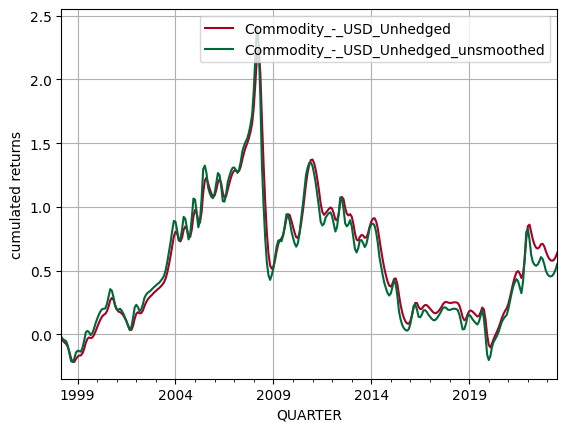

In [900]:
(unsmoothed.iloc[:,[0,9]].dropna().agg(cumulated_returns)
.plot(grid = True, cmap = 'RdYlGn',ylabel='cumulated returns')
.legend())

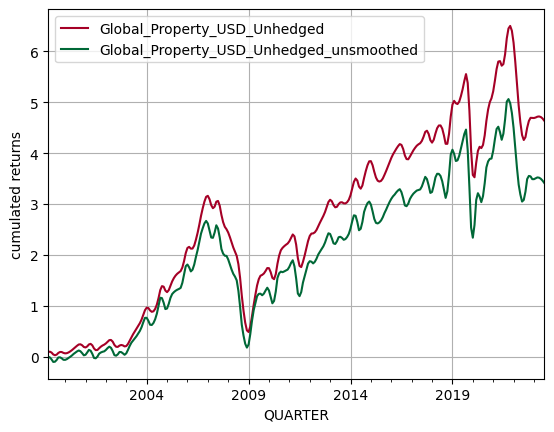

In [901]:
(unsmoothed.iloc[:,[1,10]].agg(cumulated_returns).dropna()
.plot(grid = True, cmap = 'RdYlGn',ylabel='cumulated returns')
.legend())


### Interpolation:

Text(0.5, 1.0, 'Year 2018 interpolation')

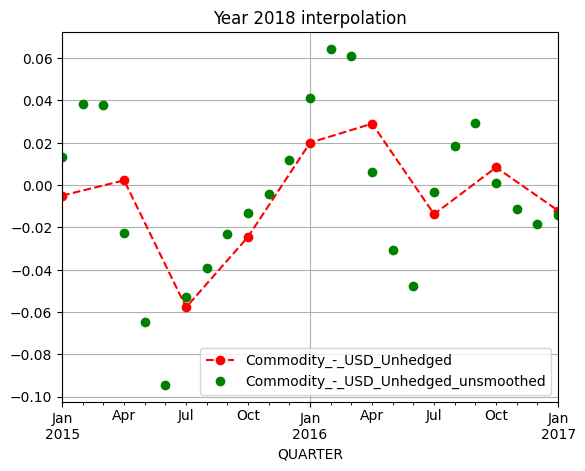

In [902]:
fig, axis = plt.subplots()
(unsmoothed.loc['2015-01-01':'2017-01-01', unsmoothed.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

axis.set_title('Year 2018 interpolation')

###  Serial correlation:

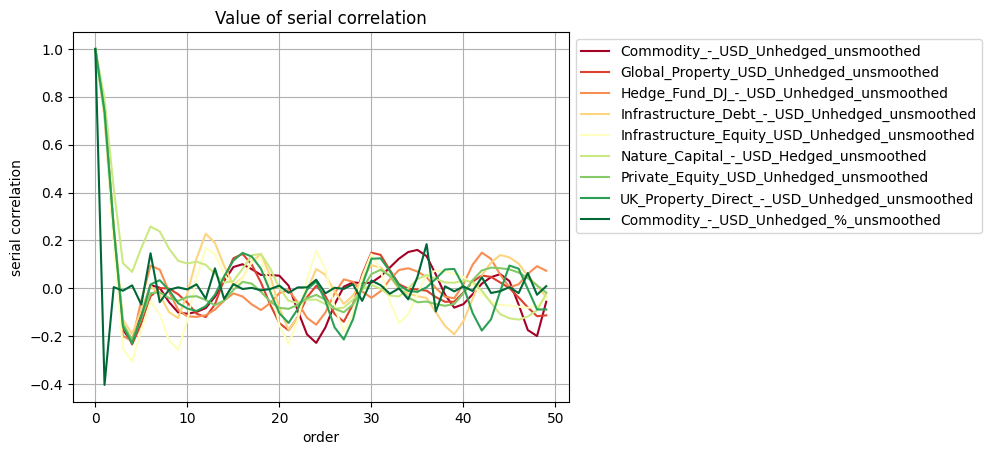

In [903]:
serial_correlation_unsmoothed = pd.DataFrame({name:[unsmoothed[name].dropna().autocorr(k) for k in range (50)]
for name in unsmoothed.iloc[:,9:].columns})

(serial_correlation_unsmoothed
.plot(grid = True, cmap  = 'RdYlGn', xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

### Volatility:

In [904]:
import numpy as np

def volatility_from_month(x):
    return np.sqrt(12)*x.std()

In [905]:
(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]]
.loc['2017-12-31':'2022-12-31']
.dropna()
.agg(volatility_from_month))

Commodity_-_USD_Unhedged_unsmoothed               0.165632
Global_Property_USD_Unhedged_unsmoothed           0.183171
Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed           0.059985
Infrastructure_Debt_-_USD_Unhedged_unsmoothed     0.044851
Infrastructure_Equity_USD_Unhedged_unsmoothed     0.153414
Nature_Capital_-_USD_Hedged_unsmoothed            0.107021
Private_Equity_USD_Unhedged_unsmoothed            0.269352
UK_Property_Direct_-_USD_Unhedged_unsmoothed      0.196684
Commodity_-_USD_Unhedged_%_unsmoothed            19.611469
dtype: float64

In [906]:
# plt.figure(figsize=(8, 6))
# corr_matrix  = unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]].corr()
# sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
# plt.title('Correlation matrix after unsmoothing')
# plt.show()

(unsmoothed[[col for col in unsmoothed.columns if "unsmoothed" in col]]
    .loc['2017-12-31':'2022-12-31']
    .corr()
    .style
    .format(precision = 2)
    .background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
    #.to_latex("tex_figure/autocorrel__after_unsmoothing.tex")
)

,Commodity_-_USD_Unhedged_unsmoothed,Global_Property_USD_Unhedged_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_unsmoothed,Infrastructure_Equity_USD_Unhedged_unsmoothed,Nature_Capital_-_USD_Hedged_unsmoothed,Private_Equity_USD_Unhedged_unsmoothed,UK_Property_Direct_-_USD_Unhedged_unsmoothed,Commodity_-_USD_Unhedged_%_unsmoothed
Commodity_-_USD_Unhedged_unsmoothed,1.00,0.65,0.81,-0.26,0.48,0.77,0.61,0.63,0.00
Global_Property_USD_Unhedged_unsmoothed,0.65,1.00,0.84,0.22,0.81,0.65,0.92,0.90,-0.10
Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,0.81,0.84,1.00,-0.10,0.67,0.74,0.90,0.76,-0.05
Infrastructure_Debt_-_USD_Unhedged_unsmoothed,-0.26,0.22,-0.10,1.00,0.32,-0.36,0.19,0.25,-0.05
Infrastructure_Equity_USD_Unhedged_unsmoothed,0.48,0.81,0.67,0.32,1.00,0.47,0.80,0.89,-0.03
Nature_Capital_-_USD_Hedged_unsmoothed,0.77,0.65,0.74,-0.36,0.47,1.00,0.61,0.54,-0.08
Private_Equity_USD_Unhedged_unsmoothed,0.61,0.92,0.90,0.19,0.80,0.61,1.00,0.85,-0.09
UK_Property_Direct_-_USD_Unhedged_unsmoothed,0.63,0.90,0.76,0.25,0.89,0.54,0.85,1.00,-0.06
Commodity_-_USD_Unhedged_%_unsmoothed,0.00,-0.10,-0.05,-0.05,-0.03,-0.08,-0.09,-0.06,1.00


## Alternative: Linear interpolation
###  Applying linear interpolation:

In [907]:
def data_unsmoothing_linear(df_):
    new = df_.resample('MS').interpolate(method='linear').pct_change()
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed_linear = data_unsmoothing_linear(alternative_data.iloc[:,0:9])


Text(0.5, 1.0, 'Year 2018 interpolation')

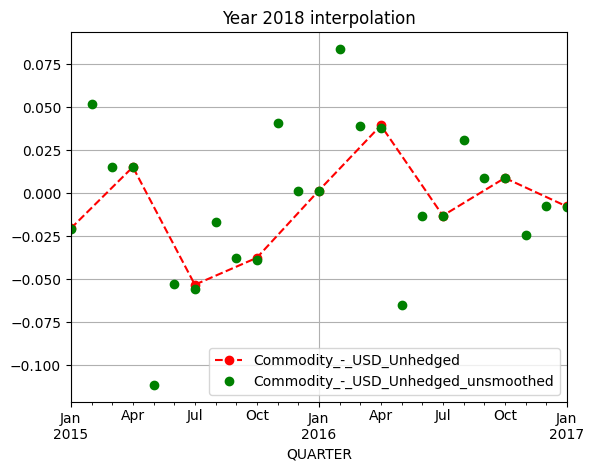

In [908]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

axis.set_title('Year 2018 interpolation')

In [909]:
unsmoothed_linear["Global_Property_USD_Unhedged"]

QUARTER
1993-10-01         NaN
1993-11-01         NaN
1993-12-01         NaN
1994-01-01         NaN
1994-02-01         NaN
                ...   
2023-03-01    0.001806
2023-04-01    0.001803
2023-05-01   -0.004701
2023-06-01   -0.004723
2023-07-01   -0.004745
Freq: MS, Name: Global_Property_USD_Unhedged, Length: 358, dtype: float64

Text(0.5, 1.0, 'Year 2018 interpolation: Linear vs Quadratic')

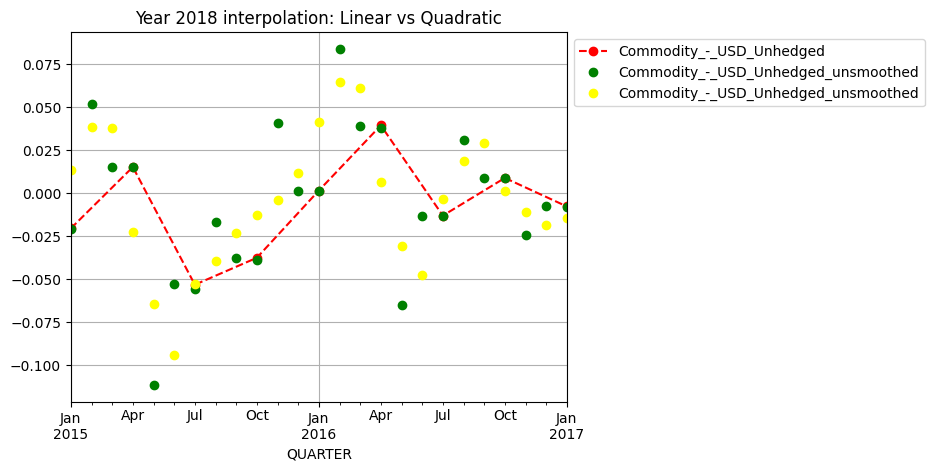

In [910]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'red')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='green')
.legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[9]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend(bbox_to_anchor = (1,1)))

axis.set_title('Year 2018 interpolation: Linear vs Quadratic')

### Correlation matrix for Linear desmoothing

In [911]:
plt.figure(figsize=(8, 6))
corr_matrix  = unsmoothed_linear[[col for col in unsmoothed_linear.columns if "unsmoothed" in col]].corr()
(corr_matrix.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex("tex_figure/Correlation_matrix_after_unsmoothing_linear.tex")
)
# sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
# plt.title('Correlation matrix after unsmoothing (linear)')
# plt.show()

,Commodity_-_USD_Unhedged_unsmoothed,Global_Property_USD_Unhedged_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_unsmoothed,Infrastructure_Equity_USD_Unhedged_unsmoothed,Nature_Capital_-_USD_Hedged_unsmoothed,Private_Equity_USD_Unhedged_unsmoothed,UK_Property_Direct_-_USD_Unhedged_unsmoothed,Commodity_-_USD_Unhedged_%_unsmoothed
Commodity_-_USD_Unhedged_unsmoothed,1.00,0.39,0.48,-0.37,0.61,0.30,0.36,0.41,0.07
Global_Property_USD_Unhedged_unsmoothed,0.39,1.00,0.64,0.00,0.64,0.39,0.83,0.83,0.03
Hedge_Fund_DJ_-_USD_Unhedged_unsmoothed,0.48,0.64,1.00,-0.35,0.69,0.43,0.79,0.49,-0.01
Infrastructure_Debt_-_USD_Unhedged_unsmoothed,-0.37,0.00,-0.35,1.00,-0.17,-0.21,-0.16,-0.04,0.09
Infrastructure_Equity_USD_Unhedged_unsmoothed,0.61,0.64,0.69,-0.17,1.00,0.33,0.71,0.74,0.01
Nature_Capital_-_USD_Hedged_unsmoothed,0.30,0.39,0.43,-0.21,0.33,1.00,0.41,0.37,0.01
Private_Equity_USD_Unhedged_unsmoothed,0.36,0.83,0.79,-0.16,0.71,0.41,1.00,0.71,-0.01
UK_Property_Direct_-_USD_Unhedged_unsmoothed,0.41,0.83,0.49,-0.04,0.74,0.37,0.71,1.00,0.01
Commodity_-_USD_Unhedged_%_unsmoothed,0.07,0.03,-0.01,0.09,0.01,0.01,-0.01,0.01,1.00


<Figure size 800x600 with 0 Axes>

## AR with rebasing

In [912]:
import pandas as pd
data = pd.read_csv('AR_Model/Ar_interpolated_data.csv', index_col=0)
data.head()

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
QUARTER,,,,,,,,
2016-01-31,-0.002679,0.019494,-0.011259,0.010706,0.004793,-0.022723,0.003603,-0.022337
2016-02-29,0.012098,0.016886,-0.012361,0.012762,0.002504,-0.015610,-0.002103,-0.024076
2016-03-31,-0.005173,0.016993,0.001499,0.004207,0.003954,-0.008041,0.004877,-0.025457
2016-04-30,0.060912,0.011057,0.003507,0.013766,-0.006403,0.033408,-0.022437,-0.048151
2016-05-31,0.069220,0.010549,0.007401,0.015675,-0.007587,0.046811,-0.025386,-0.055922


## Correlation matrix

In [913]:
(data.loc['2017-12-31':'2022-12-31'].corr()
.style.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None))

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged
Commodity_-_USD_Unhedged,1.00,0.66,0.82,-0.27,0.48,0.77,0.63,0.64
Global_Property_USD_Unhedged,0.66,1.00,0.85,0.21,0.83,0.67,0.92,0.89
Hedge_Fund_DJ_-_USD_Unhedged,0.82,0.85,1.00,-0.12,0.70,0.76,0.92,0.78
Infrastructure_Debt_-_USD_Unhedged,-0.27,0.21,-0.12,1.00,0.33,-0.35,0.16,0.24
Infrastructure_Equity_USD_Unhedged,0.48,0.83,0.70,0.33,1.00,0.51,0.82,0.89
Nature_Capital_-_USD_Hedged,0.77,0.67,0.76,-0.35,0.51,1.00,0.64,0.57
Private_Equity_USD_Unhedged,0.63,0.92,0.92,0.16,0.82,0.64,1.00,0.86
UK_Property_Direct_-_USD_Unhedged,0.64,0.89,0.78,0.24,0.89,0.57,0.86,1.00


In [914]:
data.loc['2017-12-31':'2022-12-31'].agg(volatility_from_month)

Commodity_-_USD_Unhedged              0.163115
Global_Property_USD_Unhedged          0.185239
Hedge_Fund_DJ_-_USD_Unhedged          0.061495
Infrastructure_Debt_-_USD_Unhedged    0.043048
Infrastructure_Equity_USD_Unhedged    0.156103
Nature_Capital_-_USD_Hedged           0.105529
Private_Equity_USD_Unhedged           0.274993
UK_Property_Direct_-_USD_Unhedged     0.193355
dtype: float64

## **IV. Getmansky, Lo, Makarov Model**

In [915]:
from web_app.apps.Models.getmansky.GetmanskyMain import GetmanskyModel

In [916]:
alternative_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Alternative Asset", index_col=0)
)

def tweak_data(df_):
    return (df_
            .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns})
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ["Infrastructure_Equity_Listed_-_USD_Unhedged", "Infrastructure_Equity_Listed_-_USD_Unhedged_%"])
        )

alternative_asset_data = tweak_data(alternative_asset_data)[1:]
alternative_asset_data

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
QUARTER,,,,,,,,,,,,,,,,
1994-Q1,NaN,NaN,NaN,NaN,NaN,NaN,389.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101506,NaN
1994-Q2,NaN,NaN,NaN,NaN,NaN,NaN,400.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029835,NaN
1994-Q3,NaN,NaN,NaN,NaN,NaN,NaN,415.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036681,NaN
1994-Q4,NaN,NaN,NaN,NaN,NaN,NaN,416.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001613,NaN
1995-Q1,NaN,NaN,NaN,NaN,NaN,NaN,438.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054864,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-Q3,240.5519,4817.520307,727.68,2122.80,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.138062,0.036852,-0.093622,-0.206764
2022-Q4,245.8892,5159.896609,733.63,2173.62,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.139286,0.031887,0.135844,0.118531
2023-Q1,232.7065,5213.347074,735.54,2241.04,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,-0.031233,0.001511,0.069182,0.019827


In [917]:
classic_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Classic Asset", index_col=1)
)

def tweak_data(df_):
    return (
        df_
        .resample('ME')
        .last()
        .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns if df_[col].dtype != object})
        .rename(lambda c: c.replace(' ','_'), axis = 1)
        .reset_index()
        .assign(QUARTER=lambda x: x["QUARTER"].bfill()) #only one value is missing in the dataframe
        .set_index("QUARTER")        
    )

classic_asset_data = tweak_data(classic_asset_data)[1:]
classic_asset_data

,Date,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%
QUARTER,,,,,,,,,
1998-Q1,1998-03-31,146.135886,3099.360000,242.190000,952.750061,0.004613,0.052027,0.002733,0.003693
1998-Q2,1998-04-30,146.872656,3136.193000,243.270000,958.766296,0.005042,0.011884,0.004459,0.006315
1998-Q2,1998-05-31,147.551539,3073.750000,245.790000,970.149414,0.004622,-0.019910,0.010359,0.011873
1998-Q2,1998-06-30,148.232494,3206.355000,248.630000,977.322327,0.004615,0.043141,0.011555,0.007394
1998-Q3,1998-07-31,149.008144,3175.110000,249.020000,976.397705,0.005233,-0.009745,0.001569,-0.000946
...,...,...,...,...,...,...,...,...,...
2023-Q2,2023-04-30,118.444827,18414.905335,604.922865,3095.666047,NaN,NaN,NaN,NaN
2023-Q2,2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719
2023-Q2,2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197


In [918]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'
rebase = True
#rebase parameter : True of False


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[starting_date:]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values, 
                  df[col].values
        )
    index = df[col].dropna().index
    if len(index)>1:
        bench = df.loc[index, benchmark]
        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
        )
        df[col+'_unsmoothed'] = np.nan
        rebase_ = df[col].dropna().values if rebase else None
        df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=rebase_)
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0

#switching to improve readability
if window is None: window = 0


# rebasing
df = (
    df
    .assign(**{
        col: df[col].iloc[len(df[col])-df[col].count()+window:]
        for col in alternative_asset_data.columns if "%" in col
    })    
    .pipe(lambda df_temp : df_temp.assign(**{
        col: df_temp[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns
    }))
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%" in col
    }))
    .pipe(lambda df_temp : df_temp.assign(**{
        col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
            [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns if "%" in col
    }))
)
df

,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,...,Private_Equity_USD_Unhedged_%_TR,UK_Property_Direct_-_USD_Unhedged_%_TR,Commodity_-_USD_Unhedged_%_unsmoothed_TR,Global_Property_USD_Unhedged_%_unsmoothed_TR,Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Equity_USD_Unhedged_%_unsmoothed_TR,Nature_Capital_-_USD_Hedged_%_unsmoothed_TR,Private_Equity_USD_Unhedged_%_unsmoothed_TR,UK_Property_Direct_-_USD_Unhedged_%_unsmoothed_TR
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,209.595314,4746.318242,396.361307,1636.913168,0.004287,0.042866,0.005154,0.007339,0.0000,0.000000,...,NaN,NaN,0.029541,0.052727,0.018423,-0.000137,0.033951,0.017829,0.082386,0.042667
2007-05-31,210.621198,4912.532227,392.801298,1620.550443,0.004895,0.035020,-0.008982,-0.009996,0.0000,0.000000,...,NaN,NaN,0.053931,0.098024,0.034196,0.000507,0.063288,0.033533,0.155535,0.078389
2007-06-30,211.529871,4830.392818,392.630607,1612.621733,0.004314,-0.016720,-0.000435,-0.004893,328.0290,3588.940000,...,0.034310,-0.069443,-0.001288,-0.058513,0.051898,-0.011913,0.067446,0.037361,0.034310,-0.069443
2007-07-31,212.474737,4680.877256,399.142490,1616.351994,0.004467,-0.030953,0.016585,0.002313,0.0000,0.000000,...,NaN,NaN,-0.026762,-0.094783,0.042218,-0.004789,0.047673,0.032439,-0.024540,-0.103338
2007-08-31,213.387689,4751.955901,405.399826,1629.433074,0.004297,0.015185,0.015677,0.008093,0.0000,0.000000,...,NaN,NaN,-0.018102,-0.078028,0.050622,-0.002184,0.062628,0.042107,0.004877,-0.091674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,118.444827,18414.905335,604.922865,3095.666047,0.000138,0.004671,0.004163,0.004787,0.0000,0.000000,...,NaN,NaN,-0.290755,0.375158,0.854417,1.078772,1.520407,1.677253,0.848748,-0.291237
2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719,0.0000,0.000000,...,NaN,NaN,-0.295442,0.365264,0.854941,1.088516,1.519129,1.685300,0.831967,-0.297808
2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197,226.7436,5241.647937,...,0.984109,-0.302762,-0.309660,0.375042,0.878302,1.077837,1.416197,1.664911,0.984109,-0.302762


In [919]:
df_ = df.loc[vol_start_date:vol_end_date]
print(f"volatilité annualisé\ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
volatility = pd.DataFrame({"volatilité" : [df_[name].resample("QE").last().dropna().std()*np.sqrt(4)
for name in alternative_asset_data.columns if "%" in name]}, index = [name for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé
calculées du 2017-12-31 au 2022-12-31 inclus :


,volatilité
Commodity_-_USD_Unhedged_%,0.190461
Global_Property_USD_Unhedged_%,0.207186
Hedge_Fund_DJ_-_USD_Unhedged_%,0.067181
Infrastructure_Debt_-_USD_Unhedged_%,0.058823
Infrastructure_Equity_USD_Unhedged_%,0.166568
Nature_Capital_-_USD_Hedged_%,0.136313
Private_Equity_USD_Unhedged_%,0.301945
UK_Property_Direct_-_USD_Unhedged_%,0.223793


In [920]:
df_ = df.loc[vol_start_date:vol_end_date]

param_window = "rolling " if window is not None and window != 0 else ""
param_rebase = "rebased " if rebase else ""

print(f"volatilités annualisées unsmoothed {param_window}and {param_rebase}\ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
volatility = pd.DataFrame({"volatilité" : [df_[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%" in name])
volatility

volatilités annualisées unsmoothed and rebased 
calculées du 2017-12-31 au 2022-12-31 inclus :


,volatilité
Commodity_-_USD_Unhedged_%_unsmoothed,0.189504
Global_Property_USD_Unhedged_%_unsmoothed,0.206693
Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed,0.065921
Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed,0.061503
Infrastructure_Equity_USD_Unhedged_%_unsmoothed,0.162109
Nature_Capital_-_USD_Hedged_%_unsmoothed,0.133290
Private_Equity_USD_Unhedged_%_unsmoothed,0.309443
UK_Property_Direct_-_USD_Unhedged_%_unsmoothed,0.221598


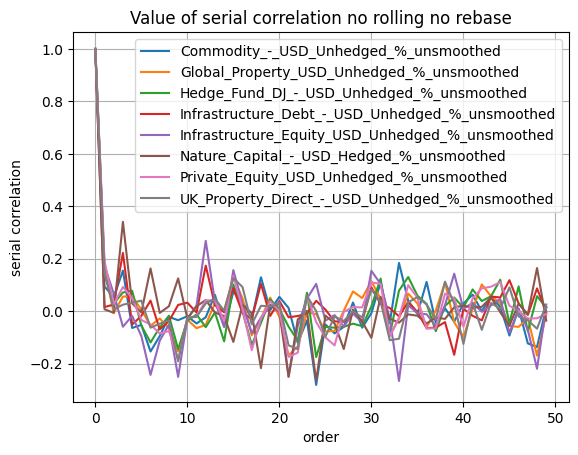

In [921]:
serial_correlation = pd.DataFrame({name+"_unsmoothed":[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation no rolling no rebase' )
.legend(bbox_to_anchor = (1,1)))


plt.show()

In [922]:
df

,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,...,Private_Equity_USD_Unhedged_%_TR,UK_Property_Direct_-_USD_Unhedged_%_TR,Commodity_-_USD_Unhedged_%_unsmoothed_TR,Global_Property_USD_Unhedged_%_unsmoothed_TR,Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Equity_USD_Unhedged_%_unsmoothed_TR,Nature_Capital_-_USD_Hedged_%_unsmoothed_TR,Private_Equity_USD_Unhedged_%_unsmoothed_TR,UK_Property_Direct_-_USD_Unhedged_%_unsmoothed_TR
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,209.595314,4746.318242,396.361307,1636.913168,0.004287,0.042866,0.005154,0.007339,0.0000,0.000000,...,NaN,NaN,0.029541,0.052727,0.018423,-0.000137,0.033951,0.017829,0.082386,0.042667
2007-05-31,210.621198,4912.532227,392.801298,1620.550443,0.004895,0.035020,-0.008982,-0.009996,0.0000,0.000000,...,NaN,NaN,0.053931,0.098024,0.034196,0.000507,0.063288,0.033533,0.155535,0.078389
2007-06-30,211.529871,4830.392818,392.630607,1612.621733,0.004314,-0.016720,-0.000435,-0.004893,328.0290,3588.940000,...,0.034310,-0.069443,-0.001288,-0.058513,0.051898,-0.011913,0.067446,0.037361,0.034310,-0.069443
2007-07-31,212.474737,4680.877256,399.142490,1616.351994,0.004467,-0.030953,0.016585,0.002313,0.0000,0.000000,...,NaN,NaN,-0.026762,-0.094783,0.042218,-0.004789,0.047673,0.032439,-0.024540,-0.103338
2007-08-31,213.387689,4751.955901,405.399826,1629.433074,0.004297,0.015185,0.015677,0.008093,0.0000,0.000000,...,NaN,NaN,-0.018102,-0.078028,0.050622,-0.002184,0.062628,0.042107,0.004877,-0.091674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,118.444827,18414.905335,604.922865,3095.666047,0.000138,0.004671,0.004163,0.004787,0.0000,0.000000,...,NaN,NaN,-0.290755,0.375158,0.854417,1.078772,1.520407,1.677253,0.848748,-0.291237
2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719,0.0000,0.000000,...,NaN,NaN,-0.295442,0.365264,0.854941,1.088516,1.519129,1.685300,0.831967,-0.297808
2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197,226.7436,5241.647937,...,0.984109,-0.302762,-0.309660,0.375042,0.878302,1.077837,1.416197,1.664911,0.984109,-0.302762


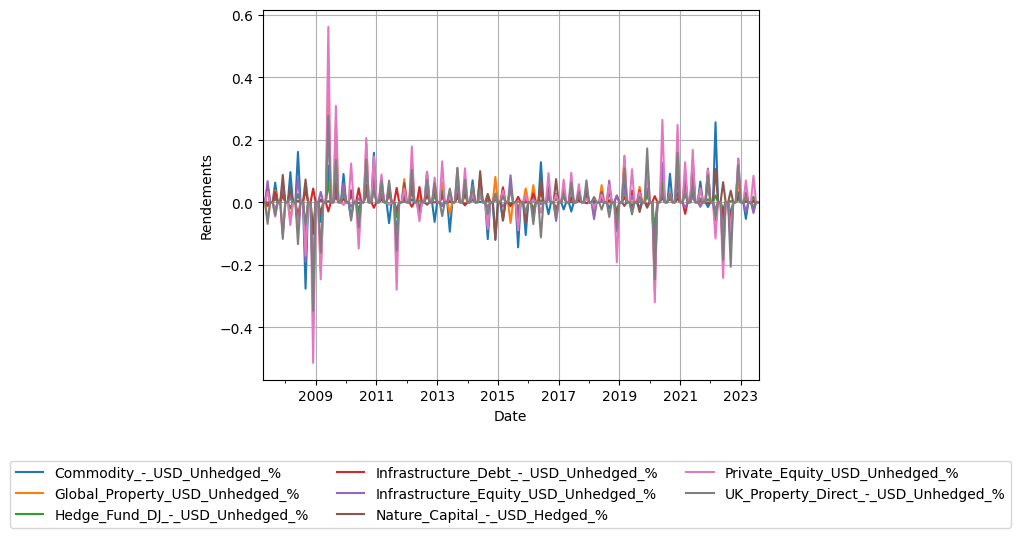

In [923]:
(df[[col for col in alternative_asset_data.columns if "%" in col ]]
    .plot()
    .legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3))

plt.xlabel("Date")
plt.ylabel("Rendements")
plt.grid()
plt.savefig("figure4.pgf", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [924]:
df

,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,...,Private_Equity_USD_Unhedged_%_TR,UK_Property_Direct_-_USD_Unhedged_%_TR,Commodity_-_USD_Unhedged_%_unsmoothed_TR,Global_Property_USD_Unhedged_%_unsmoothed_TR,Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Equity_USD_Unhedged_%_unsmoothed_TR,Nature_Capital_-_USD_Hedged_%_unsmoothed_TR,Private_Equity_USD_Unhedged_%_unsmoothed_TR,UK_Property_Direct_-_USD_Unhedged_%_unsmoothed_TR
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,209.595314,4746.318242,396.361307,1636.913168,0.004287,0.042866,0.005154,0.007339,0.0000,0.000000,...,NaN,NaN,0.029541,0.052727,0.018423,-0.000137,0.033951,0.017829,0.082386,0.042667
2007-05-31,210.621198,4912.532227,392.801298,1620.550443,0.004895,0.035020,-0.008982,-0.009996,0.0000,0.000000,...,NaN,NaN,0.053931,0.098024,0.034196,0.000507,0.063288,0.033533,0.155535,0.078389
2007-06-30,211.529871,4830.392818,392.630607,1612.621733,0.004314,-0.016720,-0.000435,-0.004893,328.0290,3588.940000,...,0.034310,-0.069443,-0.001288,-0.058513,0.051898,-0.011913,0.067446,0.037361,0.034310,-0.069443
2007-07-31,212.474737,4680.877256,399.142490,1616.351994,0.004467,-0.030953,0.016585,0.002313,0.0000,0.000000,...,NaN,NaN,-0.026762,-0.094783,0.042218,-0.004789,0.047673,0.032439,-0.024540,-0.103338
2007-08-31,213.387689,4751.955901,405.399826,1629.433074,0.004297,0.015185,0.015677,0.008093,0.0000,0.000000,...,NaN,NaN,-0.018102,-0.078028,0.050622,-0.002184,0.062628,0.042107,0.004877,-0.091674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,118.444827,18414.905335,604.922865,3095.666047,0.000138,0.004671,0.004163,0.004787,0.0000,0.000000,...,NaN,NaN,-0.290755,0.375158,0.854417,1.078772,1.520407,1.677253,0.848748,-0.291237
2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719,0.0000,0.000000,...,NaN,NaN,-0.295442,0.365264,0.854941,1.088516,1.519129,1.685300,0.831967,-0.297808
2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197,226.7436,5241.647937,...,0.984109,-0.302762,-0.309660,0.375042,0.878302,1.077837,1.416197,1.664911,0.984109,-0.302762


rendements 
calculées du 2007-04-30 au 2023-08-31 inclus :


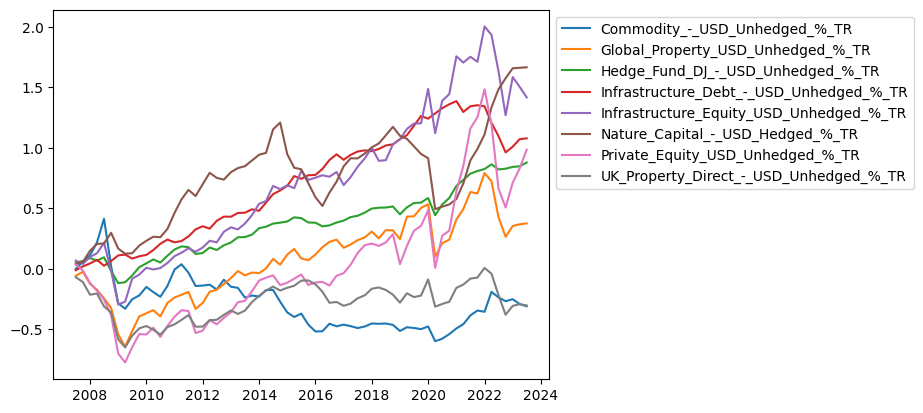

In [925]:
df_ = df

param_window = "rolling " if window is not None and window != 0 else ""
param_rebase = "rebased " if rebase else ""

print(f"rendements \ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
df_ = df_[[col+"_TR" for col in alternative_asset_data.columns if "%" in col]].dropna()
for col in df_.columns:
    plt.plot(df_[col].index, df_[col], label = col)
plt.legend(bbox_to_anchor = (1,1))
plt.show()

rendements 
calculées du 2007-04-30 au 2023-08-31 inclus :


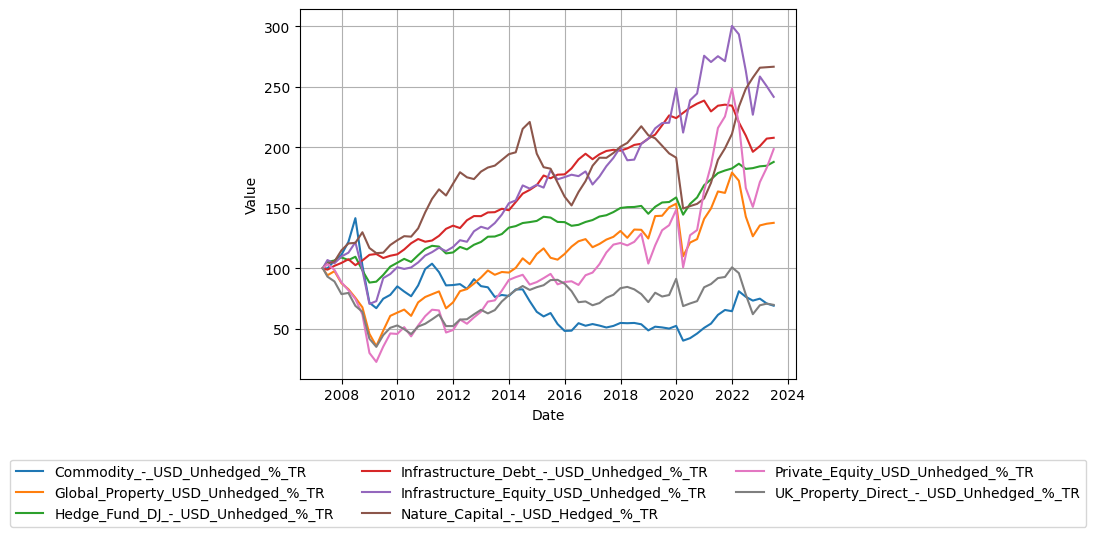

In [926]:
df_ = df

param_window = "rolling " if window is not None and window != 0 else ""
param_rebase = "rebased " if rebase else ""

print(f"rendements \ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
df_ = df_[[col+"_TR" for col in alternative_asset_data.columns if "%" in col]]
df_.iloc[0,:] = 0
df_ = (df_+1)*100
df_ = df_[[col+"_TR" for col in alternative_asset_data.columns if "%" in col]].dropna()
for col in df_.columns:
    plt.plot(df_[col].index, df_[col], label = col)

plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.savefig("figure3.pgf", bbox_inches='tight', pad_inches=0.1)
plt.show()

Rendements unsmoothed and rebased 
calculées du 2007-04-30 au 2023-08-31 inclus :


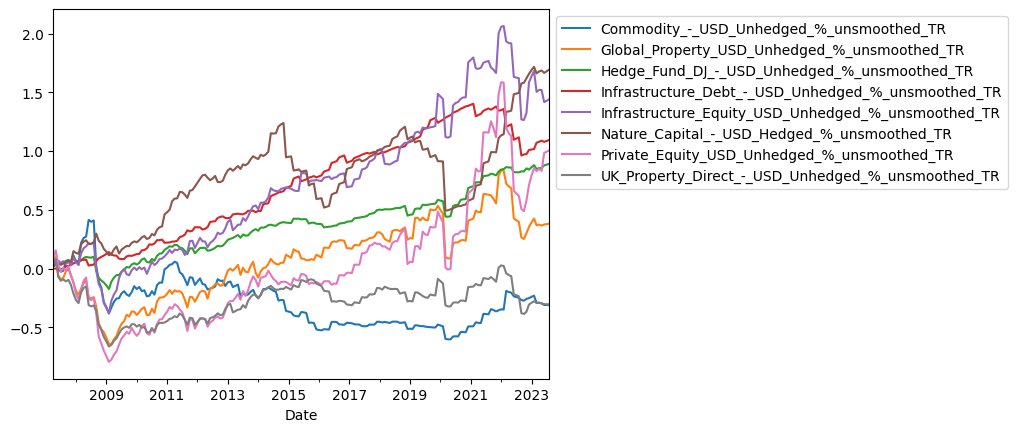

In [927]:
df_ = df

param_window = "rolling " if window is not None and window != 0 else ""
param_rebase = "rebased " if rebase else ""

print(f"Rendements unsmoothed {param_window}and {param_rebase}\ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")

(df_[[col for col in df_.columns if "%_unsmoothed_TR" in col]]
    .plot()
    .legend(bbox_to_anchor = (1,1))
)

In [928]:
np.corrcoef(df["Global_Property_USD_Unhedged_%"], df["US_Equity_USD_Unhedged_%"])

array([[1.        , 0.17738542],
       [0.17738542, 1.        ]])

In [929]:
np.corrcoef(df["Global_Property_USD_Unhedged_%"], df["Liquidity_USD_Unhedged_%"])

array([[ 1.        , -0.14703244],
       [-0.14703244,  1.        ]])

In [930]:
df

,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,...,Private_Equity_USD_Unhedged_%_TR,UK_Property_Direct_-_USD_Unhedged_%_TR,Commodity_-_USD_Unhedged_%_unsmoothed_TR,Global_Property_USD_Unhedged_%_unsmoothed_TR,Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed_TR,Infrastructure_Equity_USD_Unhedged_%_unsmoothed_TR,Nature_Capital_-_USD_Hedged_%_unsmoothed_TR,Private_Equity_USD_Unhedged_%_unsmoothed_TR,UK_Property_Direct_-_USD_Unhedged_%_unsmoothed_TR
Date,,,,,,,,,,,,,,,,,,,,,
2007-04-30,209.595314,4746.318242,396.361307,1636.913168,0.004287,0.042866,0.005154,0.007339,0.0000,0.000000,...,NaN,NaN,0.029541,0.052727,0.018423,-0.000137,0.033951,0.017829,0.082386,0.042667
2007-05-31,210.621198,4912.532227,392.801298,1620.550443,0.004895,0.035020,-0.008982,-0.009996,0.0000,0.000000,...,NaN,NaN,0.053931,0.098024,0.034196,0.000507,0.063288,0.033533,0.155535,0.078389
2007-06-30,211.529871,4830.392818,392.630607,1612.621733,0.004314,-0.016720,-0.000435,-0.004893,328.0290,3588.940000,...,0.034310,-0.069443,-0.001288,-0.058513,0.051898,-0.011913,0.067446,0.037361,0.034310,-0.069443
2007-07-31,212.474737,4680.877256,399.142490,1616.351994,0.004467,-0.030953,0.016585,0.002313,0.0000,0.000000,...,NaN,NaN,-0.026762,-0.094783,0.042218,-0.004789,0.047673,0.032439,-0.024540,-0.103338
2007-08-31,213.387689,4751.955901,405.399826,1629.433074,0.004297,0.015185,0.015677,0.008093,0.0000,0.000000,...,NaN,NaN,-0.018102,-0.078028,0.050622,-0.002184,0.062628,0.042107,0.004877,-0.091674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,118.444827,18414.905335,604.922865,3095.666047,0.000138,0.004671,0.004163,0.004787,0.0000,0.000000,...,NaN,NaN,-0.290755,0.375158,0.854417,1.078772,1.520407,1.677253,0.848748,-0.291237
2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719,0.0000,0.000000,...,NaN,NaN,-0.295442,0.365264,0.854941,1.088516,1.519129,1.685300,0.831967,-0.297808
2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197,226.7436,5241.647937,...,0.984109,-0.302762,-0.309660,0.375042,0.878302,1.077837,1.416197,1.664911,0.984109,-0.302762


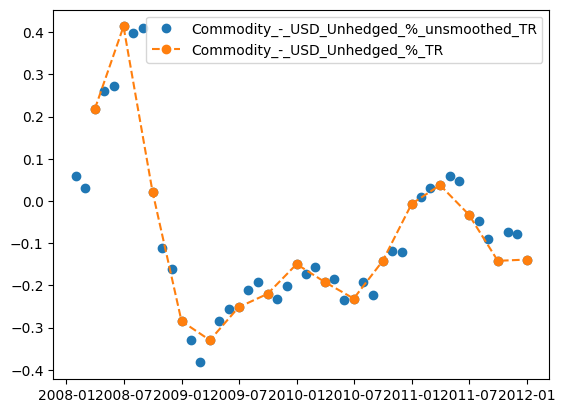

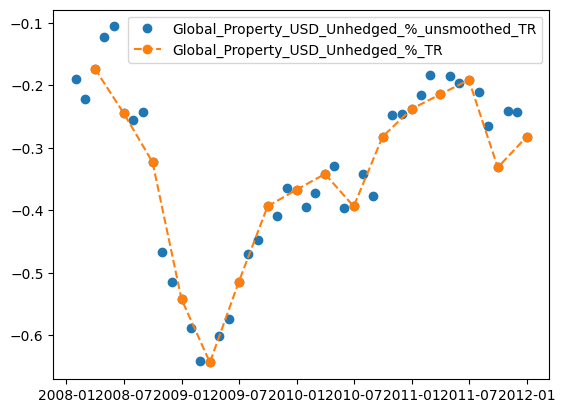

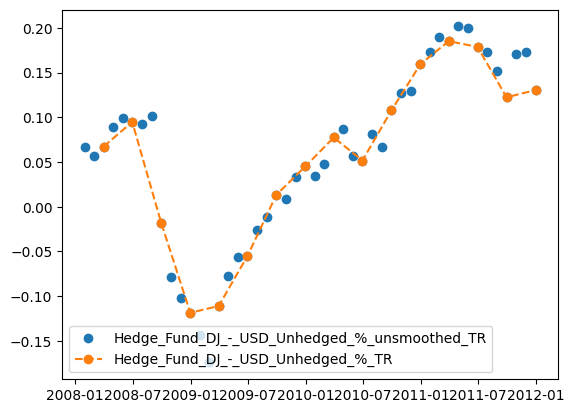

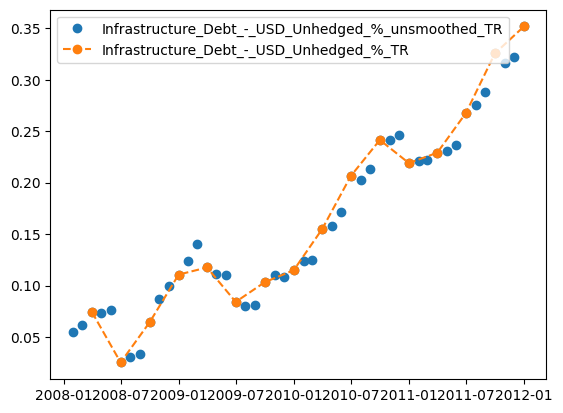

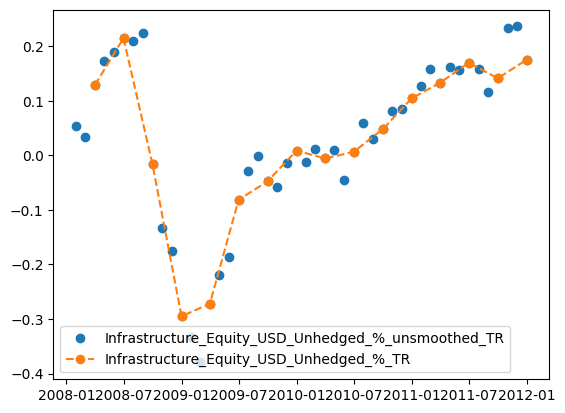

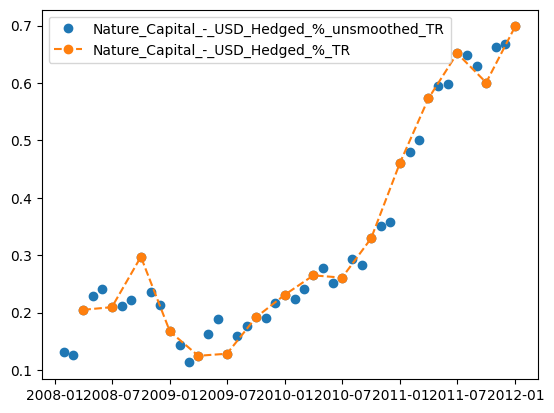

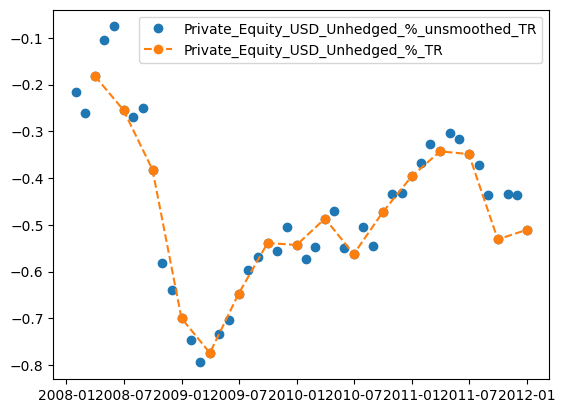

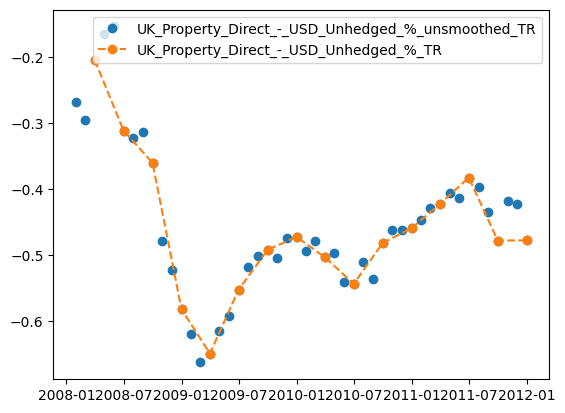

In [931]:
df_ = df.loc["2008":"2011"]
gen = [col for col in df_.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df_.index, df_[col],
        marker = 'o',
        linestyle = '',
        label = col)
    plt.plot(df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"].index, df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"],
        marker = 'o',
        linestyle = '--',
        label = col[:-14]+"_TR")
    plt.legend()
    plt.show()

### Getmansky avec window

In [932]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = 12 # choose an int or put None
benchmark = 'USD_Corporate_Bond_-_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'
rebase = True
#rebase parameter : True of False

df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[starting_date:]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values, 
                  df[col].values
        )
    index = df[col].dropna().index
    if len(index)>1:
        bench = df.loc[index, benchmark]
        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
        )
        df[col+'_unsmoothed'] = np.nan
        rebase_ = df[col].dropna().values if rebase else None
        df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=rebase_)
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0

#switching to improve readability
if window is None: window = 0


# rebasing
df = (
    df
    .assign(**{
        col: df[col].iloc[len(df[col])-df[col].count()+window:]
        for col in alternative_asset_data.columns if "%" in col
    })    
    .pipe(lambda df_temp : df_temp.assign(**{
        col: df_temp[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns
    }))
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%" in col
    }))
    .pipe(lambda df_temp : df_temp.assign(**{
        col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
            [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns if "%" in col
    }))
)

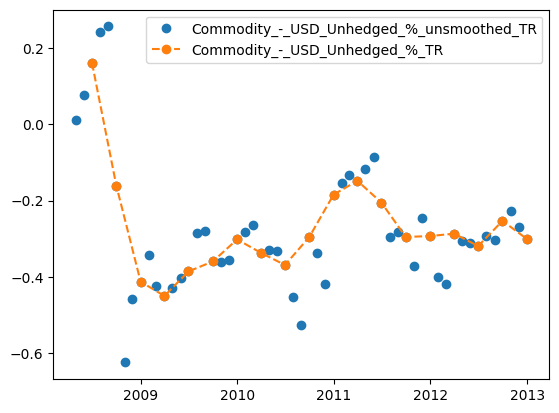

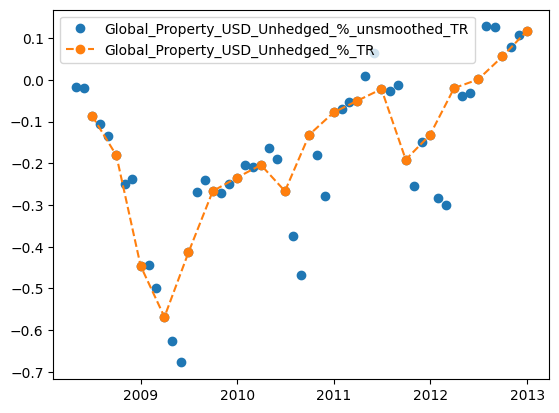

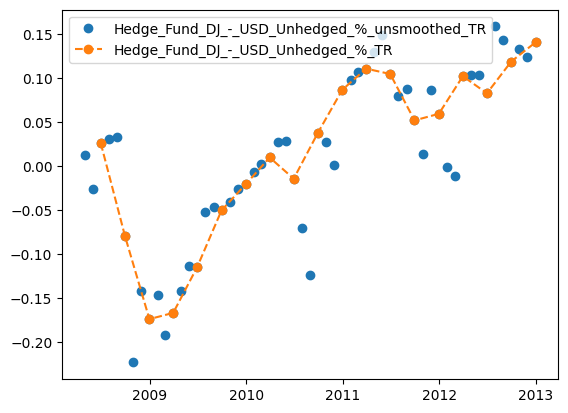

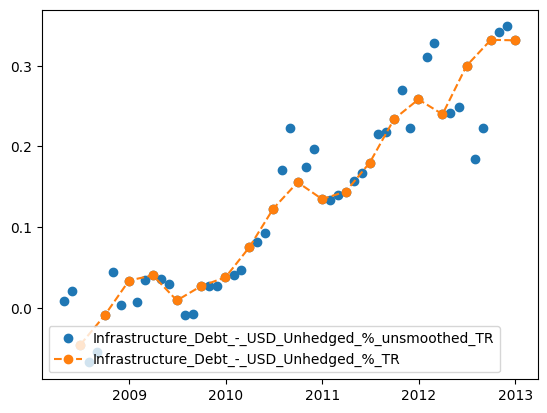

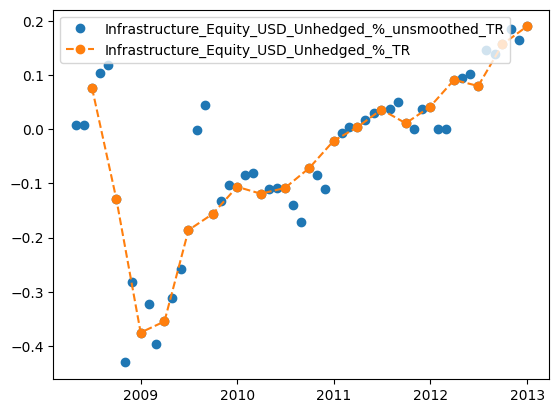

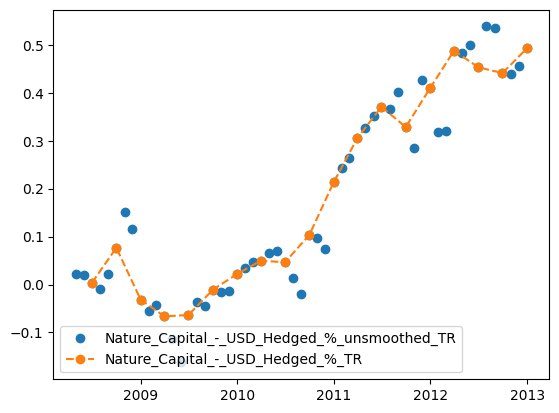

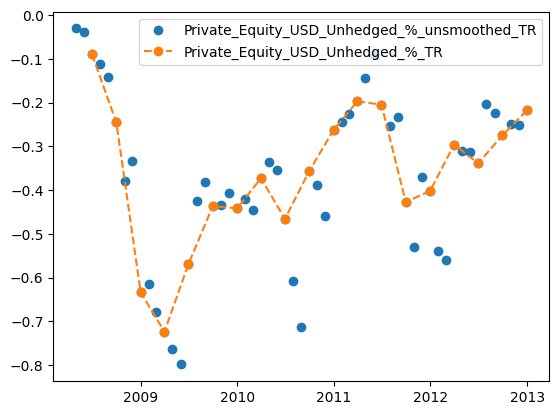

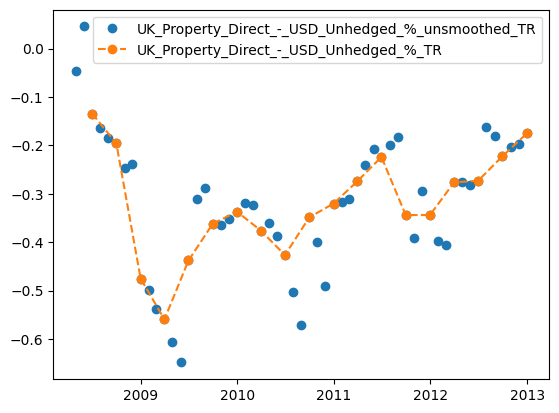

In [933]:
df_ = df.loc["2008":"2012"]
gen = [col for col in df_.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df_.index, df_[col],
        marker = 'o',
        linestyle = '',
        label = col)
    plt.plot(df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"].index, df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]+"_TR"],
        marker = 'o',
        linestyle = '--',
        label = col[:-14]+"_TR")
    plt.legend()
    plt.show()

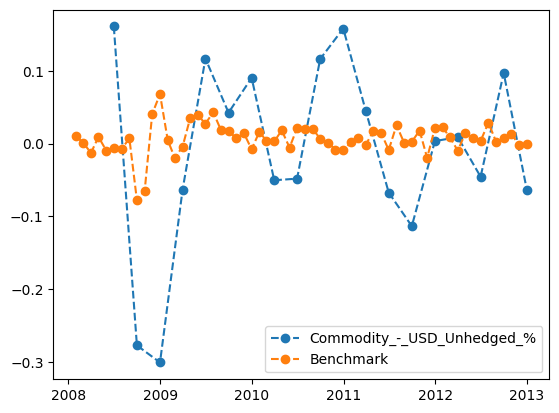

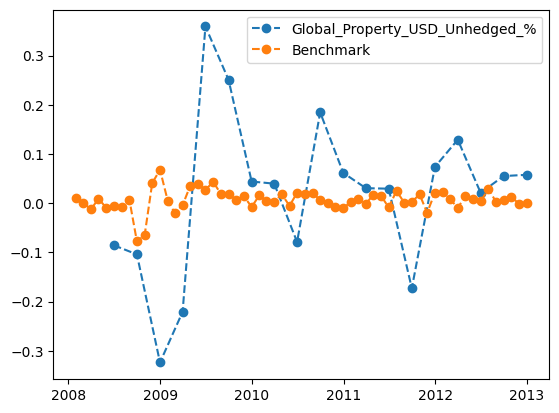

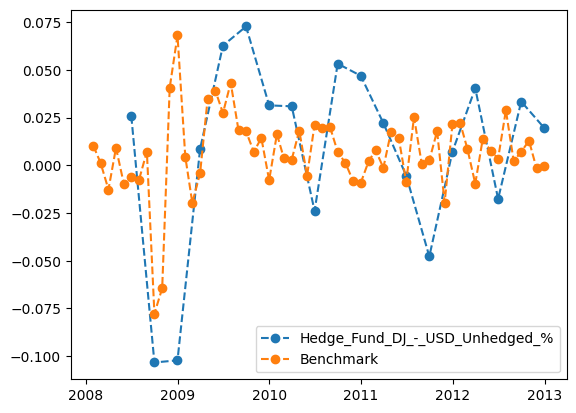

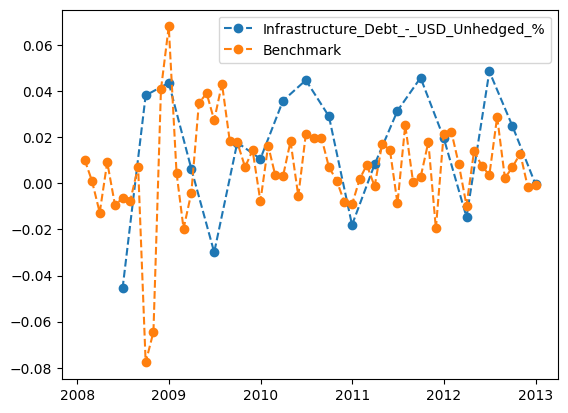

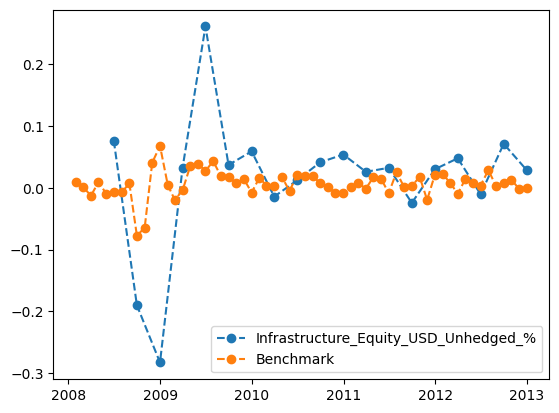

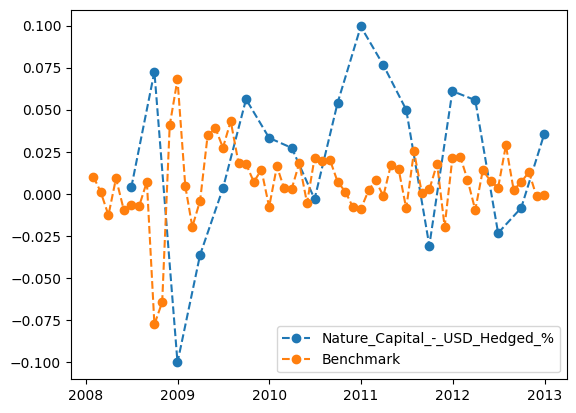

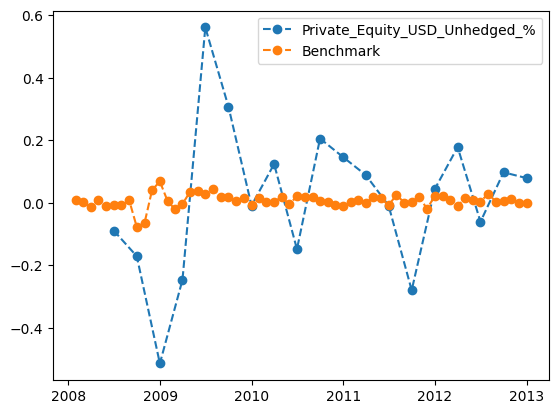

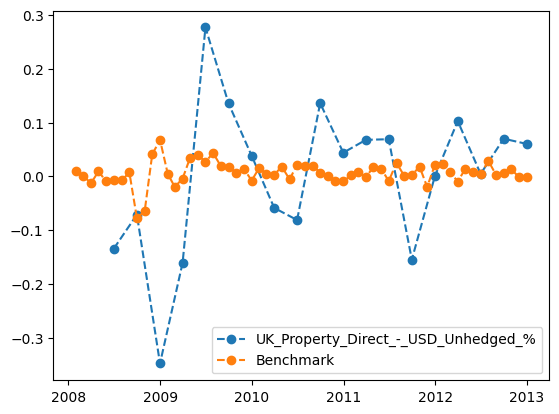

In [934]:
df_ = df.loc["2008":"2012"]
gen = [col for col in df_.columns if "%_unsmoothed_TR" in col]
for col in gen:
    plt.plot(df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]].index, df_.loc[df_.index.month.isin([3, 6, 9, 12]), col[:-14]],
        marker = 'o',
        linestyle = '--',
        label = col[:-14])
    plt.plot(df_.index, df_[benchmark],
        marker = 'o',
        linestyle = '--',
        label = "Benchmark")
    plt.legend()
    plt.show()

In [935]:
df_ = df[vol_start_date:vol_end_date]
print(f"volatilité annualisé\ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
volatility = pd.DataFrame({"volatilité" : [df_[name].resample("QE").last().dropna().std()*np.sqrt(4)
for name in alternative_asset_data.columns if "%" in name]}, index = [name for name in alternative_asset_data.columns if "%" in name])
volatility

volatilité annualisé
calculées du 2017-12-31 au 2022-12-31 inclus :


,volatilité
Commodity_-_USD_Unhedged_%,0.190461
Global_Property_USD_Unhedged_%,0.207186
Hedge_Fund_DJ_-_USD_Unhedged_%,0.067181
Infrastructure_Debt_-_USD_Unhedged_%,0.058823
Infrastructure_Equity_USD_Unhedged_%,0.166568
Nature_Capital_-_USD_Hedged_%,0.136313
Private_Equity_USD_Unhedged_%,0.301945
UK_Property_Direct_-_USD_Unhedged_%,0.223793


In [936]:
df_ = df[vol_start_date:vol_end_date]

param_window = "rolling " if window is not None and window != 0 else ""
param_rebase = "rebased " if rebase else ""

print(f"volatilités annualisées unsmoothed {param_window}and {param_rebase}\ncalculées du {df_.index[0].date()} au {df_.index[-1].date()} inclus :")
volatility = pd.DataFrame({"volatilité" : [df_[name+"_unsmoothed"].dropna().std()*np.sqrt(12)
for name in alternative_asset_data.columns if "%" in name]}, index = [name+"_unsmoothed" for name in alternative_asset_data.columns if "%" in name])
volatility

volatilités annualisées unsmoothed rolling and rebased 
calculées du 2017-12-31 au 2022-12-31 inclus :


,volatilité
Commodity_-_USD_Unhedged_%_unsmoothed,3.309778
Global_Property_USD_Unhedged_%_unsmoothed,0.361657
Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed,0.160878
Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed,0.171722
Infrastructure_Equity_USD_Unhedged_%_unsmoothed,0.383088
Nature_Capital_-_USD_Hedged_%_unsmoothed,0.197729
Private_Equity_USD_Unhedged_%_unsmoothed,0.523904
UK_Property_Direct_-_USD_Unhedged_%_unsmoothed,0.417146


Serial correlation
benchmark : USD_Corporate_Bond_-_USD_Unhedged_%
from 2007-04-30 to 2023-08-31


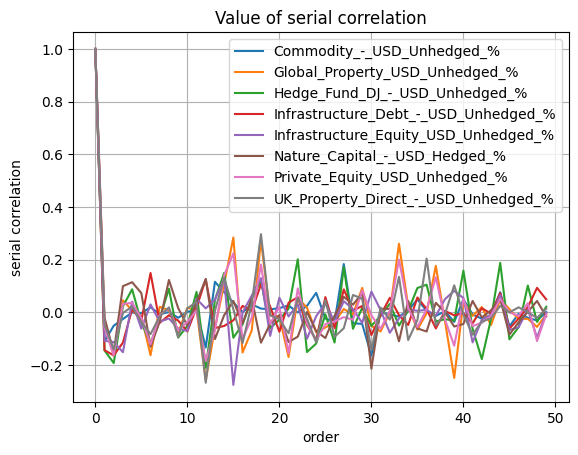

In [937]:
serial_correlation = pd.DataFrame({name:[df[name+"_unsmoothed"].dropna().autocorr(k) for k in range (50)]
for name in alternative_asset_data.columns if "%" in name})

(serial_correlation
.plot(grid = True, xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

print(f"Serial correlation\nbenchmark : {benchmark}\nfrom {df.index[0].date()} to {df.index[-1].date()}")

plt.show()

### Délire de la correlation

In [938]:
df_ = df[vol_start_date:vol_end_date]

print(f"Correlation matrix\nbenchmark : {benchmark}\nfrom {df_.index[0].date()} to {df_.index[-1].date()}")

(pd.DataFrame({name: df_[name].dropna()
for name in alternative_asset_data.columns if "%" in name})
.resample("QE")
.last()
.corr()
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex('tex_figure/base.tex')
)

Correlation matrix
benchmark : USD_Corporate_Bond_-_USD_Unhedged_%
from 2017-12-31 to 2022-12-31


,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
Commodity_-_USD_Unhedged_%,1.00,0.61,0.78,-0.23,0.39,0.75,0.54,0.57
Global_Property_USD_Unhedged_%,0.61,1.00,0.83,0.33,0.79,0.49,0.91,0.87
Hedge_Fund_DJ_-_USD_Unhedged_%,0.78,0.83,1.00,0.01,0.62,0.60,0.87,0.73
Infrastructure_Debt_-_USD_Unhedged_%,-0.23,0.33,0.01,1.00,0.42,-0.45,0.34,0.34
Infrastructure_Equity_USD_Unhedged_%,0.39,0.79,0.62,0.42,1.00,0.23,0.77,0.85
Nature_Capital_-_USD_Hedged_%,0.75,0.49,0.60,-0.45,0.23,1.00,0.40,0.34
Private_Equity_USD_Unhedged_%,0.54,0.91,0.87,0.34,0.77,0.40,1.00,0.82
UK_Property_Direct_-_USD_Unhedged_%,0.57,0.87,0.73,0.34,0.85,0.34,0.82,1.00


In [939]:
df_ = df[vol_start_date:vol_end_date]

param_window = "rolling " if window is not None and window != 0 else "no rolling "
param_rebase = "rebased " if rebase else "no rebased "

print(f"Correlation matrix unsmoothed {param_window}and {param_rebase}\nbenchmark : {benchmark}\nfrom {df_.index[0].date()} to {df_.index[-1].date()}")
(pd.DataFrame({name+"_unsmoothed": df_[name+"_unsmoothed"].dropna()
for name in alternative_asset_data.columns if "%" in name})
.resample("ME")
.last()
.corr()
.style
.format(precision = 2)
.background_gradient(cmap = 'RdYlGn', vmin = -1, vmax = 1, axis = None)
#.to_latex("tex_figure/autocorrel_unsmoothed_window_{window}_rebased_getmansky.tex")
)

Correlation matrix unsmoothed rolling and rebased 
benchmark : USD_Corporate_Bond_-_USD_Unhedged_%
from 2017-12-31 to 2022-12-31


,Commodity_-_USD_Unhedged_%_unsmoothed,Global_Property_USD_Unhedged_%_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed,Infrastructure_Equity_USD_Unhedged_%_unsmoothed,Nature_Capital_-_USD_Hedged_%_unsmoothed,Private_Equity_USD_Unhedged_%_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%_unsmoothed
Commodity_-_USD_Unhedged_%_unsmoothed,1.00,0.45,0.57,-0.25,0.08,0.41,0.29,0.31
Global_Property_USD_Unhedged_%_unsmoothed,0.45,1.00,0.84,0.38,0.77,0.35,0.88,0.86
Hedge_Fund_DJ_-_USD_Unhedged_%_unsmoothed,0.57,0.84,1.00,0.23,0.68,0.39,0.83,0.73
Infrastructure_Debt_-_USD_Unhedged_%_unsmoothed,-0.25,0.38,0.23,1.00,0.58,-0.60,0.35,0.39
Infrastructure_Equity_USD_Unhedged_%_unsmoothed,0.08,0.77,0.68,0.58,1.00,0.03,0.87,0.85
Nature_Capital_-_USD_Hedged_%_unsmoothed,0.41,0.35,0.39,-0.60,0.03,1.00,0.35,0.21
Private_Equity_USD_Unhedged_%_unsmoothed,0.29,0.88,0.83,0.35,0.87,0.35,1.00,0.83
UK_Property_Direct_-_USD_Unhedged_%_unsmoothed,0.31,0.86,0.73,0.39,0.85,0.21,0.83,1.00


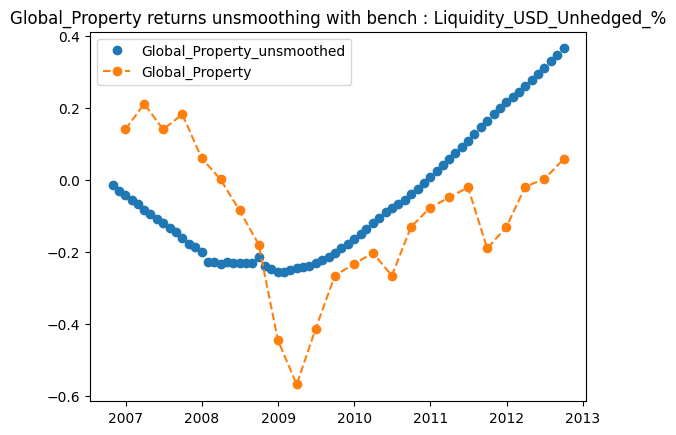

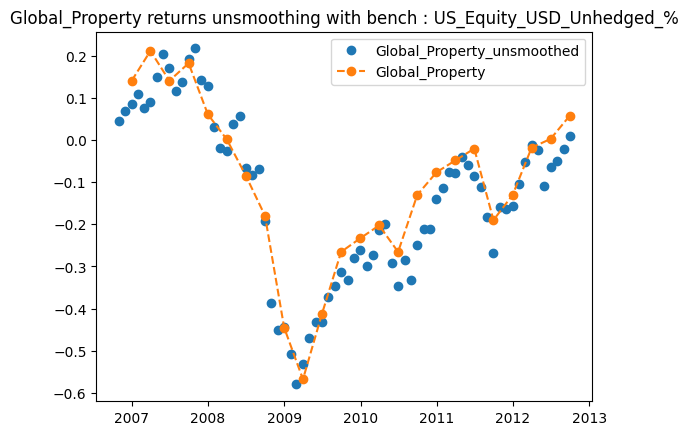

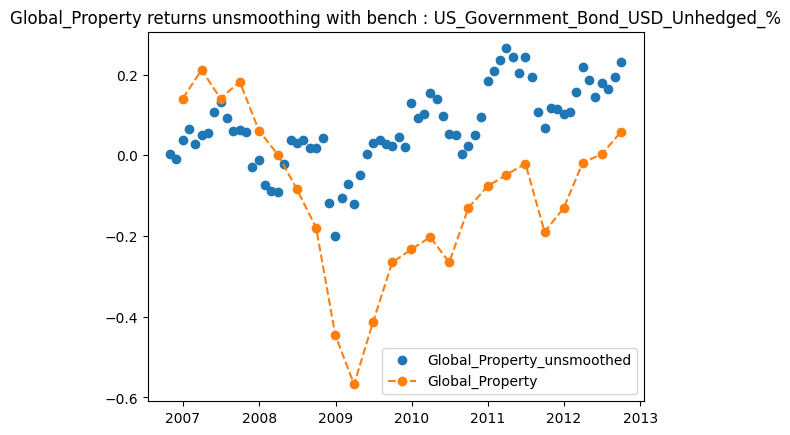

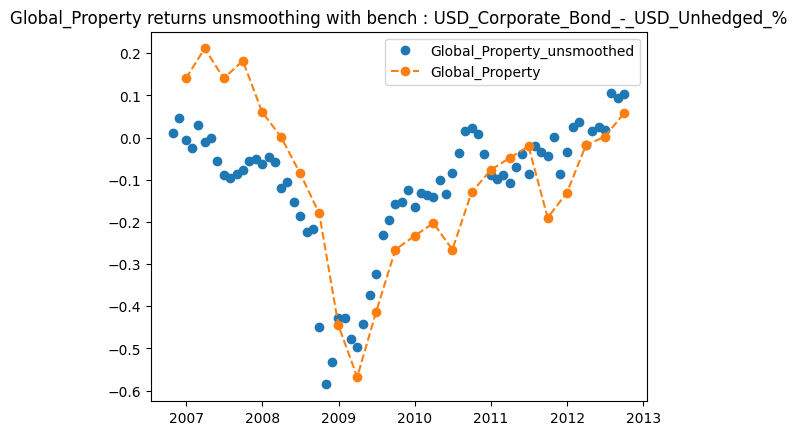

In [940]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'

for benchmark in ['Liquidity_USD_Unhedged_%', 
                  'US_Equity_USD_Unhedged_%',
                  'US_Government_Bond_USD_Unhedged_%',
                  'USD_Corporate_Bond_-_USD_Unhedged_%'
                  ]:
    df = (
        classic_asset_data
        .copy()
        .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
        .set_index("Date")
        .loc[start_date:end_date]
        .iloc[1:]
    )

    #deal with potential missing values
    if df.isna().any().any():
        df.interpolate(method='linear', inplace=True)

    for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
        getmansky = GetmanskyModel(order)

        if weight_type != "optimized":
            getmansky.set_default_weights(weight_type)
        else:
            getmansky.optimize_weights_LR(df[benchmark].values, 
                    df[col].values
                    )
        index = df[col].dropna().index
        if len(index)>3:
            bench = df.loc[index, benchmark]

            getmansky.fit(bench.values.reshape(-1, 1), 
                        df[col].dropna().values.reshape(-1,1), 
                        window = window
            )

            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench)
            # if you want to rebase add rebase=df[col].dropna().values as a parameter of the function
        else:
            warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
            df[col+'_unsmoothed'] = 0

    # switching to improve readability
    if window is None: window_ = 0


    # rebasing
    df = (
        df
        .assign(**{
            col: df[col].iloc[len(df[col])-df[col].count()+window_:]
            for col in alternative_asset_data.columns if "%" in col
        })    
        .pipe(lambda df_temp : df_temp.assign(**{
            col: df_temp[col].mul(pd.Series(
                [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
                index = df_temp[col].index
                )) 
            for col in alternative_asset_data.columns
        }))
        .pipe(lambda df_temp: df_temp.assign(**{
            col + '_TR': (df_temp[col]+1).cumprod()-1
            for col in df_temp.columns if "%" in col
        }))
        .pipe(lambda df_temp : df_temp.assign(**{
            col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
                [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
                index = df_temp[col].index
                )) 
            for col in alternative_asset_data.columns if "%" in col
        }))
    )



    fig, axes = plt.subplots()

    plt.title("Global_Property returns unsmoothing with bench : " + benchmark)

    plt.plot(df.index, df["Global_Property_USD_Unhedged_%_unsmoothed_TR"],
            marker = 'o',
            linestyle = '',
            label = "Global_Property_unsmoothed")
    plt.plot(df.loc[df.index.month.isin([3, 6, 9, 12]), 'Global_Property_USD_Unhedged_%_TR'].index, df.loc[df.index.month.isin([3, 6, 9, 12]), 'Global_Property_USD_Unhedged_%_TR'],
            marker = 'o',
            linestyle = '--',
            label = "Global_Property")

    plt.legend()
    plt.show()

In [941]:
from web_app.apps.Models.getmansky.GetmanskyMain import GetmanskyModel

In [942]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import seaborn as sns

vol_start_date = "31-12-2017"
vol_end_date = "31-12-2022"

starting_date = "31-03-2007" # rebasing in order to compare cumulative returns

In [943]:
alternative_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Alternative Asset", index_col=0)
)

def tweak_data(df_):
    return (df_
            .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns})
            .rename(lambda c: c.replace(' ','_'), axis = 1)
            .drop(columns = ["Infrastructure_Equity_Listed_-_USD_Unhedged", "Infrastructure_Equity_Listed_-_USD_Unhedged_%"])
        )

alternative_asset_data = tweak_data(alternative_asset_data)[1:]
alternative_asset_data

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%,Global_Property_USD_Unhedged_%,Hedge_Fund_DJ_-_USD_Unhedged_%,Infrastructure_Debt_-_USD_Unhedged_%,Infrastructure_Equity_USD_Unhedged_%,Nature_Capital_-_USD_Hedged_%,Private_Equity_USD_Unhedged_%,UK_Property_Direct_-_USD_Unhedged_%
QUARTER,,,,,,,,,,,,,,,,
1994-Q1,NaN,NaN,NaN,NaN,NaN,NaN,389.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101506,NaN
1994-Q2,NaN,NaN,NaN,NaN,NaN,NaN,400.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029835,NaN
1994-Q3,NaN,NaN,NaN,NaN,NaN,NaN,415.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036681,NaN
1994-Q4,NaN,NaN,NaN,NaN,NaN,NaN,416.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001613,NaN
1995-Q1,NaN,NaN,NaN,NaN,NaN,NaN,438.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054864,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-Q3,240.5519,4817.520307,727.68,2122.80,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.138062,0.036852,-0.093622,-0.206764
2022-Q4,245.8892,5159.896609,733.63,2173.62,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.139286,0.031887,0.135844,0.118531
2023-Q1,232.7065,5213.347074,735.54,2241.04,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,-0.031233,0.001511,0.069182,0.019827


In [944]:
classic_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Classic Asset", index_col=1)
)

def tweak_data(df_):
    return (
        df_
        .resample('ME')
        .last()
        .assign(**{col + '_%': df_[col].pct_change(fill_method = None) for col in df_.columns if df_[col].dtype != object})
        .rename(lambda c: c.replace(' ','_'), axis = 1)
        .reset_index()
        .assign(QUARTER=lambda x: x["QUARTER"].bfill()) #only one value is missing in the dataframe
        .set_index("QUARTER")        
    )

classic_asset_data = tweak_data(classic_asset_data)[1:]
classic_asset_data

,Date,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%,US_Equity_USD_Unhedged_%,US_Government_Bond_USD_Unhedged_%,USD_Corporate_Bond_-_USD_Unhedged_%
QUARTER,,,,,,,,,
1998-Q1,1998-03-31,146.135886,3099.360000,242.190000,952.750061,0.004613,0.052027,0.002733,0.003693
1998-Q2,1998-04-30,146.872656,3136.193000,243.270000,958.766296,0.005042,0.011884,0.004459,0.006315
1998-Q2,1998-05-31,147.551539,3073.750000,245.790000,970.149414,0.004622,-0.019910,0.010359,0.011873
1998-Q2,1998-06-30,148.232494,3206.355000,248.630000,977.322327,0.004615,0.043141,0.011555,0.007394
1998-Q3,1998-07-31,149.008144,3175.110000,249.020000,976.397705,0.005233,-0.009745,0.001569,-0.000946
...,...,...,...,...,...,...,...,...,...
2023-Q2,2023-04-30,118.444827,18414.905335,604.922865,3095.666047,NaN,NaN,NaN,NaN
2023-Q2,2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719
2023-Q2,2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197


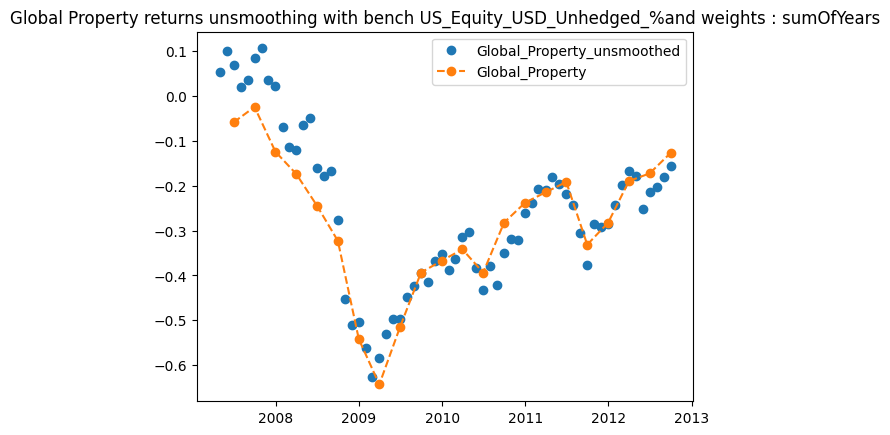

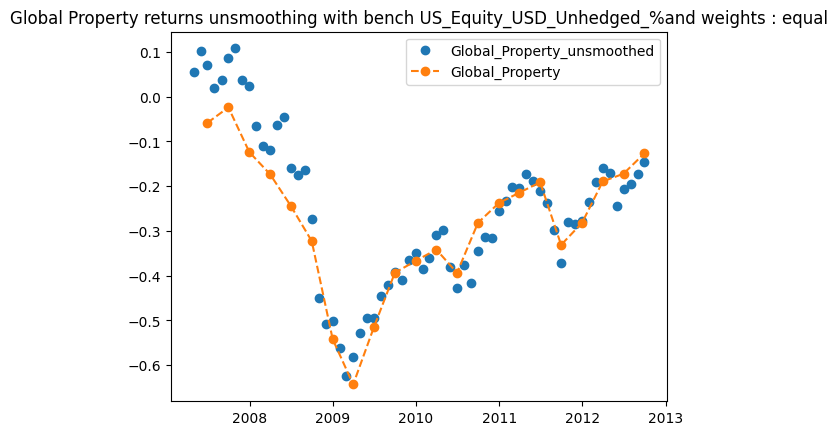

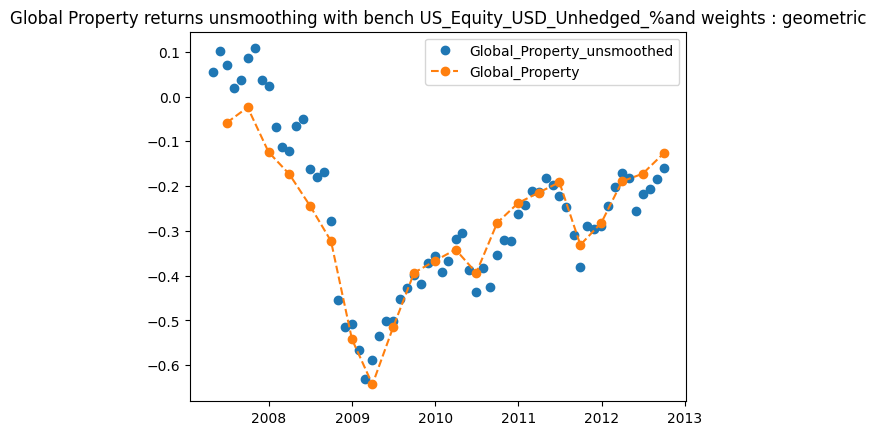

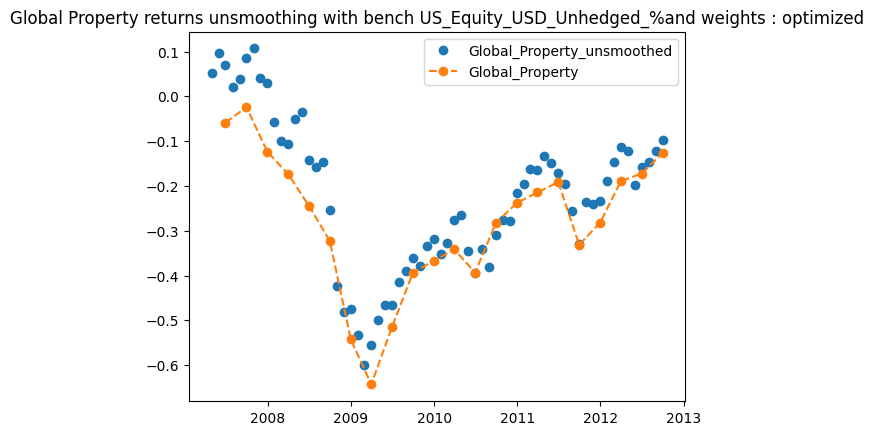

In [945]:
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2012-09-30' # format "YYYY-MM-DD"
weight_type = "optimized" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'
rebase = False
#rebase parameter : True of False
warnings.simplefilter('ignore')
for weight_type in ["sumOfYears", "equal", "geometric", "optimized"]:
    df = (
        classic_asset_data
        .copy()
        .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
        .set_index("Date")
        .loc[starting_date:]
        .loc[start_date:end_date]
        .iloc[1:]
    )

    #deal with potential missing values
    if df.isna().any().any():
        df.interpolate(method='linear', inplace=True)

    for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
        getmansky = GetmanskyModel(order)

        if weight_type != "optimized":
            getmansky.set_default_weights(weight_type, delta = 0.7)
        else:
            getmansky.optimize_weights_LR(df[benchmark].values, 
                    df[col].values
            )
            assert len(df[benchmark].values) == len(df[col].values)
        index = df[col].dropna().index
        if len(index)>1:
            bench = df.loc[index, benchmark]
            getmansky.fit(bench.values.reshape(-1, 1), 
                        df[col].dropna().values.reshape(-1,1), 
                        window = window
            )
            df[col+'_unsmoothed'] = np.nan
            rebase_ = df[col].dropna().values if rebase else None
            df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=rebase_)
        else:
            warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
            df[col+'_unsmoothed'] = 0
    #switching to improve readability
    if window is None: window_ = 0


    # rebasing
    df = (
        df
        .assign(**{
            col: df[col].iloc[len(df[col])-df[col].count()+window_:]
            for col in alternative_asset_data.columns if "%" in col
        })    
        .pipe(lambda df_temp : df_temp.assign(**{
            col: df_temp[col].mul(pd.Series(
                [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
                index = df_temp[col].index
                )) 
            for col in alternative_asset_data.columns
        }))
        .pipe(lambda df_temp: df_temp.assign(**{
            col + '_TR': (df_temp[col]+1).cumprod()-1
            for col in df_temp.columns if "%" in col
        }))
        .pipe(lambda df_temp : df_temp.assign(**{
            col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
                [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
                index = df_temp[col].index
                )) 
            for col in alternative_asset_data.columns if "%" in col
        }))
    )


    fig, axes = plt.subplots()

    plt.title("Global Property returns unsmoothing with bench " + benchmark + "and weights : " +weight_type)

    plt.plot(df.index, df["Global_Property_USD_Unhedged_%_unsmoothed_TR"],
            marker = 'o',
            linestyle = '',
            label = "Global_Property_unsmoothed")
    plt.plot(df.loc[df.index.month.isin([3, 6, 9, 12]), 'Global_Property_USD_Unhedged_%_TR'].index, df.loc[df.index.month.isin([3, 6, 9, 12]), 'Global_Property_USD_Unhedged_%_TR'],
            marker = 'o',
            linestyle = '--',
            label = "Global_Property")

    plt.legend()
    plt.show()

In [946]:
np.corrcoef(df["Nature_Capital_-_USD_Hedged_%"], df["USD_Corporate_Bond_-_USD_Unhedged_%"])

array([[ 1.        , -0.40231844],
       [-0.40231844,  1.        ]])

In [947]:
np.corrcoef(df["Global_Property_USD_Unhedged_%"], df["USD_Corporate_Bond_-_USD_Unhedged_%"])

array([[1.        , 0.00938887],
       [0.00938887, 1.        ]])

In [948]:
df["Commodity_-_USD_Unhedged"]

Date
2007-04-30      0.0000
2007-05-31      0.0000
2007-06-30    328.0290
2007-07-31      0.0000
2007-08-31      0.0000
                ...   
2012-05-31      0.0000
2012-06-30    272.3567
2012-07-31      0.0000
2012-08-31      0.0000
2012-09-30    298.7492
Name: Commodity_-_USD_Unhedged, Length: 66, dtype: float64

In [950]:
import scipy
start_date = '2006-09-30' # format "YYYY-MM-DD"
end_date = '2016-09-30' # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = 12 # choose an int or put None
benchmark = 'USD_Corporate_Bond_-_USD_Unhedged_%' #one of the following list :
# 'Liquidity_USD_Unhedged_%'
# 'US_Equity_USD_Unhedged_%'
# 'US_Government_Bond_USD_Unhedged_%'
# 'USD_Corporate_Bond_-_USD_Unhedged_%'
rebase = True
#rebase parameter : True of False

df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[starting_date:]
    .iloc[1:]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)


for col in filter(lambda x: "%" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values, 
                  df[col].values
        )
    index = df[col].dropna().index




    Benchmark = df[benchmark].values
    Rto = df[col].values
    Benchmark_, Rto_ = Benchmark, Rto
    if Rto_[0] == Rto_[1] and Rto_[1] == Rto_[2]:
        Benchmark_, Rto_ = np.array(Benchmark_), np.array(Rto_)                        
    elif Rto_[0] == Rto_[1] and Rto_[1] != Rto_[2]:
        Benchmark_, Rto_ = np.array(Benchmark_[2:]), np.array(Rto_[2:])
    elif Rto_[0] != Rto_[1] and Rto_[1] == Rto_[2]:
        Benchmark_, Rto_ = np.array(Benchmark_[1:]), np.array(Rto_[1:])

    def objective(weights_):
        _tmp = df.copy()
        _tmp['returns_bench'] = weights_[0]*_tmp['Liquidity USD Unhedged'] + weights_[1]*_tmp['US Equity USD Unhedged']+ weights_[2]*_tmp['US Government Bond USD Unhedged']+ weights_[3]*_tmp['USD Corporate Bond - USD Unhedged']
        return -np.corrcoef(_tmp['returns_bench'], _tmp[])[0,1]

    opti = scipy.optimize.minimize(objective, np.array([0.25, 0.25, 0.25, 0.25]), bounds = ((0,1), (0,1), (0,1), (0,1)), constraints = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1})
    weights_ = opti.x
    print(weights_)
    print(opti.success)

    df['returns_bench'] = weights_[0]*df["Liquidity_USD_Unhedged_%"] + weights_[1]*df["US_Equity_USD_Unhedged_%"]+ weights_[2]*df['"US_Government_Bond_USD_Unhedged_%']+ weights_[3]*df['USD_Corporate_Bond_-_USD_Unhedged_%']

    if len(index)>1:
        bench = df.loc[index, 'returns_bench']
        getmansky.fit(bench.values.reshape(-1, 1), 
                    df[col].dropna().values.reshape(-1,1), 
                    window = window
        )
        df[col+'_unsmoothed'] = np.nan
        rebase_ = df[col].dropna().values if rebase else None
        df.loc[index[window:], col+'_unsmoothed'] = getmansky.predict(bench, rebase=rebase_)
    else:
        warnings.warn(f"Be careful, {col} has no value for the selected timeframe.")
        df[col+'_unsmoothed'] = 0

#switching to improve readability
if window is None: window = 0


# rebasing
df = (
    df
    .assign(**{
        col: df[col].iloc[len(df[col])-df[col].count()+window:]
        for col in alternative_asset_data.columns if "%" in col
    })    
    .pipe(lambda df_temp : df_temp.assign(**{
        col: df_temp[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns
    }))
    .pipe(lambda df_temp: df_temp.assign(**{
        col + '_TR': (df_temp[col]+1).cumprod()-1
        for col in df_temp.columns if "%" in col
    }))
    .pipe(lambda df_temp : df_temp.assign(**{
        col+"_TR": df_temp[col+"_TR"].mul(pd.Series(
            [np.nan if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df_temp[col].index],
            index = df_temp[col].index
            )) 
        for col in alternative_asset_data.columns if "%" in col
    }))
)

KeyError: 'Liquidity USD Unhedged'